# Overview: Cluster Modeling

This notebook provides an example of how to use model simple co-eval stellar populations using the built-in `Isochrone` class and the `clusters` module.

# Preamble

As always, let's just set up a nice environment to run these tests.

In [1]:
from __future__ import print_function, division
from six.moves import range
import sys
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
import h5py

In [2]:
# plot in-line within the notebook
%matplotlib inline

# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

In [3]:
import brutus

# Isochrone

The cluster modeling in `brutus` is currently built off of the `Isochrone` class. We will load in one of the available isochrones below.

In [4]:
from brutus.seds import Isochrone
from brutus import filters as flt

# filters
flt_list = flt.gaia + flt.ps[:-2] + flt.tmass + flt.wise[:2]
Nfilts = len(flt_list)

# files
nnfile = '../data/DATAFILES/nn_c3k.h5'
mistfile = '../data/DATAFILES/MIST_1.2_iso_vvcrit0.0.h5'

# initialize isochrone
iso = Isochrone(nnfile=nnfile, mistfile=mistfile, filters=flt_list)

Filters: ['Gaia_G_MAW', 'Gaia_BP_MAWf', 'Gaia_RP_MAW', 'PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', '2MASS_J', '2MASS_H', '2MASS_Ks', 'WISE_W1', 'WISE_W2']
Constructing MIST isochrones...done!
Initializing FastNN predictor...done!


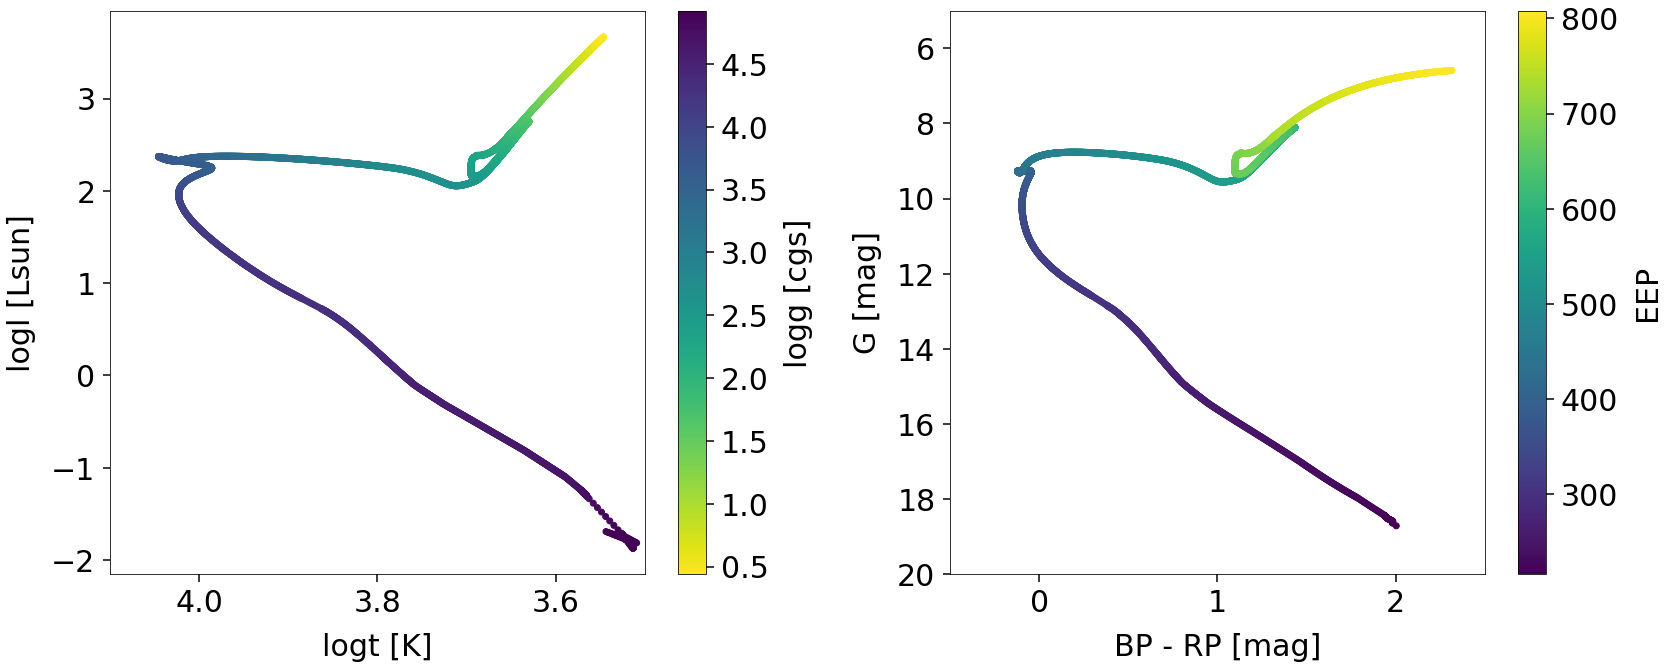

In [5]:
eep_grid = np.linspace(202, 808, 5000)
mags, params, _ = iso.get_seds(eep=eep_grid)  # example

logl, logt, logg = params['logl'], params['logt'], params['logg']
G, BP, RP = mags[:, :3].T

# plot example isochrone
plt.figure(figsize=(24, 10))
# HRD
plt.subplot(1, 2, 1)
plt.scatter(logt, logl, c=logg, cmap='viridis_r')
plt.xlabel('logt [K]')
plt.ylabel('logl [Lsun]')
plt.xlim([4.1, 3.5])
plt.colorbar(label='logg [cgs]')
# CMD
plt.subplot(1, 2, 2)
plt.scatter(BP - RP, G, c=eep_grid)
plt.xlabel('BP - RP [mag]')
plt.ylabel('G [mag]')
plt.xlim([-0.5, 2.5])
plt.ylim([20, 5])
plt.colorbar(label='EEP')
plt.tight_layout()

# Data

For this demo, we'll use data for M67 (NGC 2682) taken from in Speagle et al. (2020b) that is included in the demos folder.

In [6]:
from brutus.utils import magnitude, inv_magnitude
from astropy.io import fits

# load file
f = fits.open('NGC_2682.fits')
fdata = f[1].data
Nobj = len(fdata)

# object info
info = np.empty(Nobj, dtype=[('GAIA_DR2_ID', int),
                             ('EBV', float),
                             ('pmem', float),
                             ('parallax', float),
                             ('parallax_err', float)])
try:
    info['GAIA_DR2_ID'] = fdata['GAIA_DR2_ID']  # Gaia ID
except:
    info['GAIA_DR2_ID'] = fdata['gaia_dr2_source.source_id']
info['EBV'] = fdata['EBV']  # reddening
try:
    info['pmem'] = fdata['HDBscan_MemProb']  # HDBSCAN P(member)
except:
    info['pmem'] = np.ones_like(info['GAIA_DR2_ID'])

# parallax
try:
    parallax, parallax_err = fdata['Parallax'], fdata['Parallax_Err']
except:
    parallax, parallax_err = fdata['gaia_dr2_source.parallax'], fdata['gaia_dr2_source.parallax_error']
psel = (np.isclose(parallax_err, 0.) | 
        np.isclose(parallax, 0.) | 
        (parallax_err > 1e6))  # safety screen
parallax[psel], parallax_err[psel] = np.nan, np.nan  # filler values
parallax += 0.054  # zero-point offset (SME19)
parallax_err = np.sqrt(parallax_err**2 + 0.043**2)  # add systematic floor

info['parallax'] = parallax
info['parallax_err'] = parallax_err

# fluxes
# NOTE: FLUXES MUST BE MAG=0 NORMALIZED (flux=10**-0.4*mag)
phot, err = np.zeros((Nobj, Nfilts)), np.zeros((Nobj, Nfilts))

# Gaia DR2
sys_err_gaia = np.array([0.02, 0.02, 0.02])
gaia_fnorm = np.array([18904273853.41611, 13788594503.310804, 
                       8036741508.0079975])  # zeropoints
gaia_flux = np.c_[fdata['gaia_dr2_source.phot_g_mean_flux'],
                  fdata['gaia_dr2_source.phot_bp_mean_flux'],
                  fdata['gaia_dr2_source.phot_rp_mean_flux']] / gaia_fnorm
gaia_err = np.c_[fdata['gaia_dr2_source.phot_g_mean_flux_error'],
                 fdata['gaia_dr2_source.phot_bp_mean_flux_error'],
                 fdata['gaia_dr2_source.phot_rp_mean_flux_error']] / gaia_fnorm
gaia_err[gaia_err <= 0.] = np.nan  # screen bad values
gaia_err = np.sqrt(gaia_err**2 + (sys_err_gaia * gaia_flux)**2)  # add floor
phot[:, :3], err[:, :3] = gaia_flux, gaia_err

# PanSTARRS
sys_err_ps = np.array([0.02, 0.02, 0.02, 0.02, 0.02])
ps_flux, ps_err = fdata['ucal_fluxqz.median'], fdata['ucal_fluxqz.err']
ps_err[ps_err <= 0.] = np.nan  # screen bad values
ps_err = np.sqrt(ps_err**2 + (sys_err_ps * ps_flux)**2)  # add floor
phot[:, 3:8], err[:, 3:8] = ps_flux, ps_err

# 2MASS
sys_err_tmass = np.array([0.03, 0.03, 0.03])
try:
    tmass_mag = np.c_[fdata['2MASS_J'], 
                      fdata['2MASS_H'], 
                      fdata['2MASS_Ks']]
    tmass_magerr = np.c_[fdata['2MASS_J_Err'], 
                         fdata['2MASS_H_Err'], 
                         fdata['2MASS_Ks_Err']]
except:
    tmass_mag = np.c_[fdata['tmass.j_m'], 
                      fdata['tmass.h_m'], 
                      fdata['tmass.k_m']]
    tmass_magerr = np.c_[fdata['tmass.j_msigcom'], 
                         fdata['tmass.h_msigcom'], 
                         fdata['tmass.k_msigcom']]
tmass_magerr[tmass_magerr <= 0.] = np.nan  # screen bad values
tmass_flux, tmass_err = inv_magnitude(tmass_mag, tmass_magerr)  # mag->flux
tmass_err = np.sqrt(tmass_err**2 + (sys_err_tmass * tmass_flux)**2)  # add floor
phot[:, 8:11], err[:, 8:11] = tmass_flux, tmass_err

# WISE
sys_err_wise = np.array([0.04, 0.04])
try:
    wise_mag = np.c_[fdata['WISE_W1'], 
                     fdata['WISE_W2']]
    wise_magerr = np.c_[fdata['WISE_W1_Err'], 
                        fdata['WISE_W2_Err']]
except:
    wise_mag = np.c_[fdata['allwise.w1mpro'], 
                     fdata['allwise.w2mpro']]
    wise_magerr = np.c_[fdata['allwise.w1sigmpro'], 
                        fdata['allwise.w2sigmpro']]
wise_magerr[wise_magerr <= 0.] = np.nan  # screen bad values
wise_flux, wise_err = inv_magnitude(wise_mag, wise_magerr)  # mag->flux
wise_err = np.sqrt(wise_err**2 + (sys_err_wise * wise_flux)**2)  # add floor
phot[:, 11:13], err[:, 11:13] = wise_flux, wise_err

# create band-mask
mask = np.isfinite(phot) & np.isfinite(err) & (err > 0.) & (err < 0.5)

# print summary
nbands, nbands_counts = np.unique(np.sum(mask, axis=1), return_counts=True)
print('Number of objects:', Nobj)
print('Number of observed filters: ', nbands)
print('Corresponding object counts:', nbands_counts)

Number of objects: 1585
Number of observed filters:  [ 1  3  4  5  6  7  8  9 10 11 12 13]
Corresponding object counts: [   1    1    1    4    3    2   66   73   75  111  146 1102]


/home/joshspeagle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less_equal
/home/joshspeagle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in less_equal
/home/joshspeagle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in less_equal
/home/joshspeagle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less_equal
/home/joshspeagle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in greater
/home/joshspeagle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in less


We visualize these data below.

In [7]:
def plot_cmds(phot, err, info, parallax, parallax_err,
              flt_list=flt_list, iso_mags=None, dist=None, lnls=None,
              offsets=None):
    
    # define cmds
    cmds = [(0, 1, 2),  # G, BP-RP
        (0, 3, 4),  # G, g-r
        (0, 8, 9),  # G, J-H
        (0, 11, 12)]  # G, W1, W2
    
    # define figure
    Npanels = len(cmds) + 1
    nrows = 2
    ncols = (Npanels - 1) // 2 + 1
    plt.figure(figsize=(14 * ncols, 12 * nrows))
    
    if lnls is not None:
        colors = lnls
        label = 'loglike'
    else:
        colors = info['pmem']
        label = 'pmem'
        
    if offsets is None:
        offsets = np.ones(len(flt_list))

    # add in CMDs
    for i, (x1, x2, x3) in enumerate(cmds):
        plt.subplot(nrows, ncols, i + 2)
        m = -2.5 * np.log10(phot[:, x1] * offsets[x1])
        c = -2.5 * np.log10((phot[:, x2] * offsets[x2]) / (phot[:, x3] * offsets[x3]))
        me, ce = err[:, x1] / phot[:, x1], np.sqrt((err[:, x1] / phot[:, x1])**2 + 
                                                   (err[:, x1] / phot[:, x1])**2)
        me, ce = 2.5 / np.log(10) * me, 2.5 / np.log(10) * ce
        plt.scatter(c, m, c=colors, zorder=2)
        plt.errorbar(c, m, linestyle='none', lw=3, alpha=0.3, color='gray', zorder=1,
                     xerr=2*ce, yerr=2*me)  # plot 2-sigma errors
        if iso_mags is not None:
            [plt.plot(mag[:, x2] - mag[:, x3], mag[:, x1], 
             color='red', alpha=0.3, lw=3) for mag in iso_mags]
        plt.colorbar(label=label)
        plt.xlabel(flt_list[x2] + ' - ' + flt_list[x3])
        plt.ylabel(flt_list[x1])
        plt.ylim([max(m) + 0.5, min(m) - 0.5])

    # add in parallaxes
    plt.subplot(nrows, ncols, 1)
    plt.scatter(parallax, m, c=colors, zorder=2)
    plt.errorbar(parallax, m, linestyle='none', lw=3, alpha=0.3, color='gray', zorder=1,
                 xerr=2*parallax_err, yerr=2*me)  # plot 2-sigma errors
    if dist is not None:
        plt.vlines(1e3 / dist, 100, -100, colors='red', lw=5, alpha=0.3)
    plt.colorbar(label=label)
    plt.xlabel('Parallax')
    plt.ylabel(flt_list[x1])
    plt.ylim([max(m) + 0.5, min(m) - 0.5])

    plt.tight_layout()

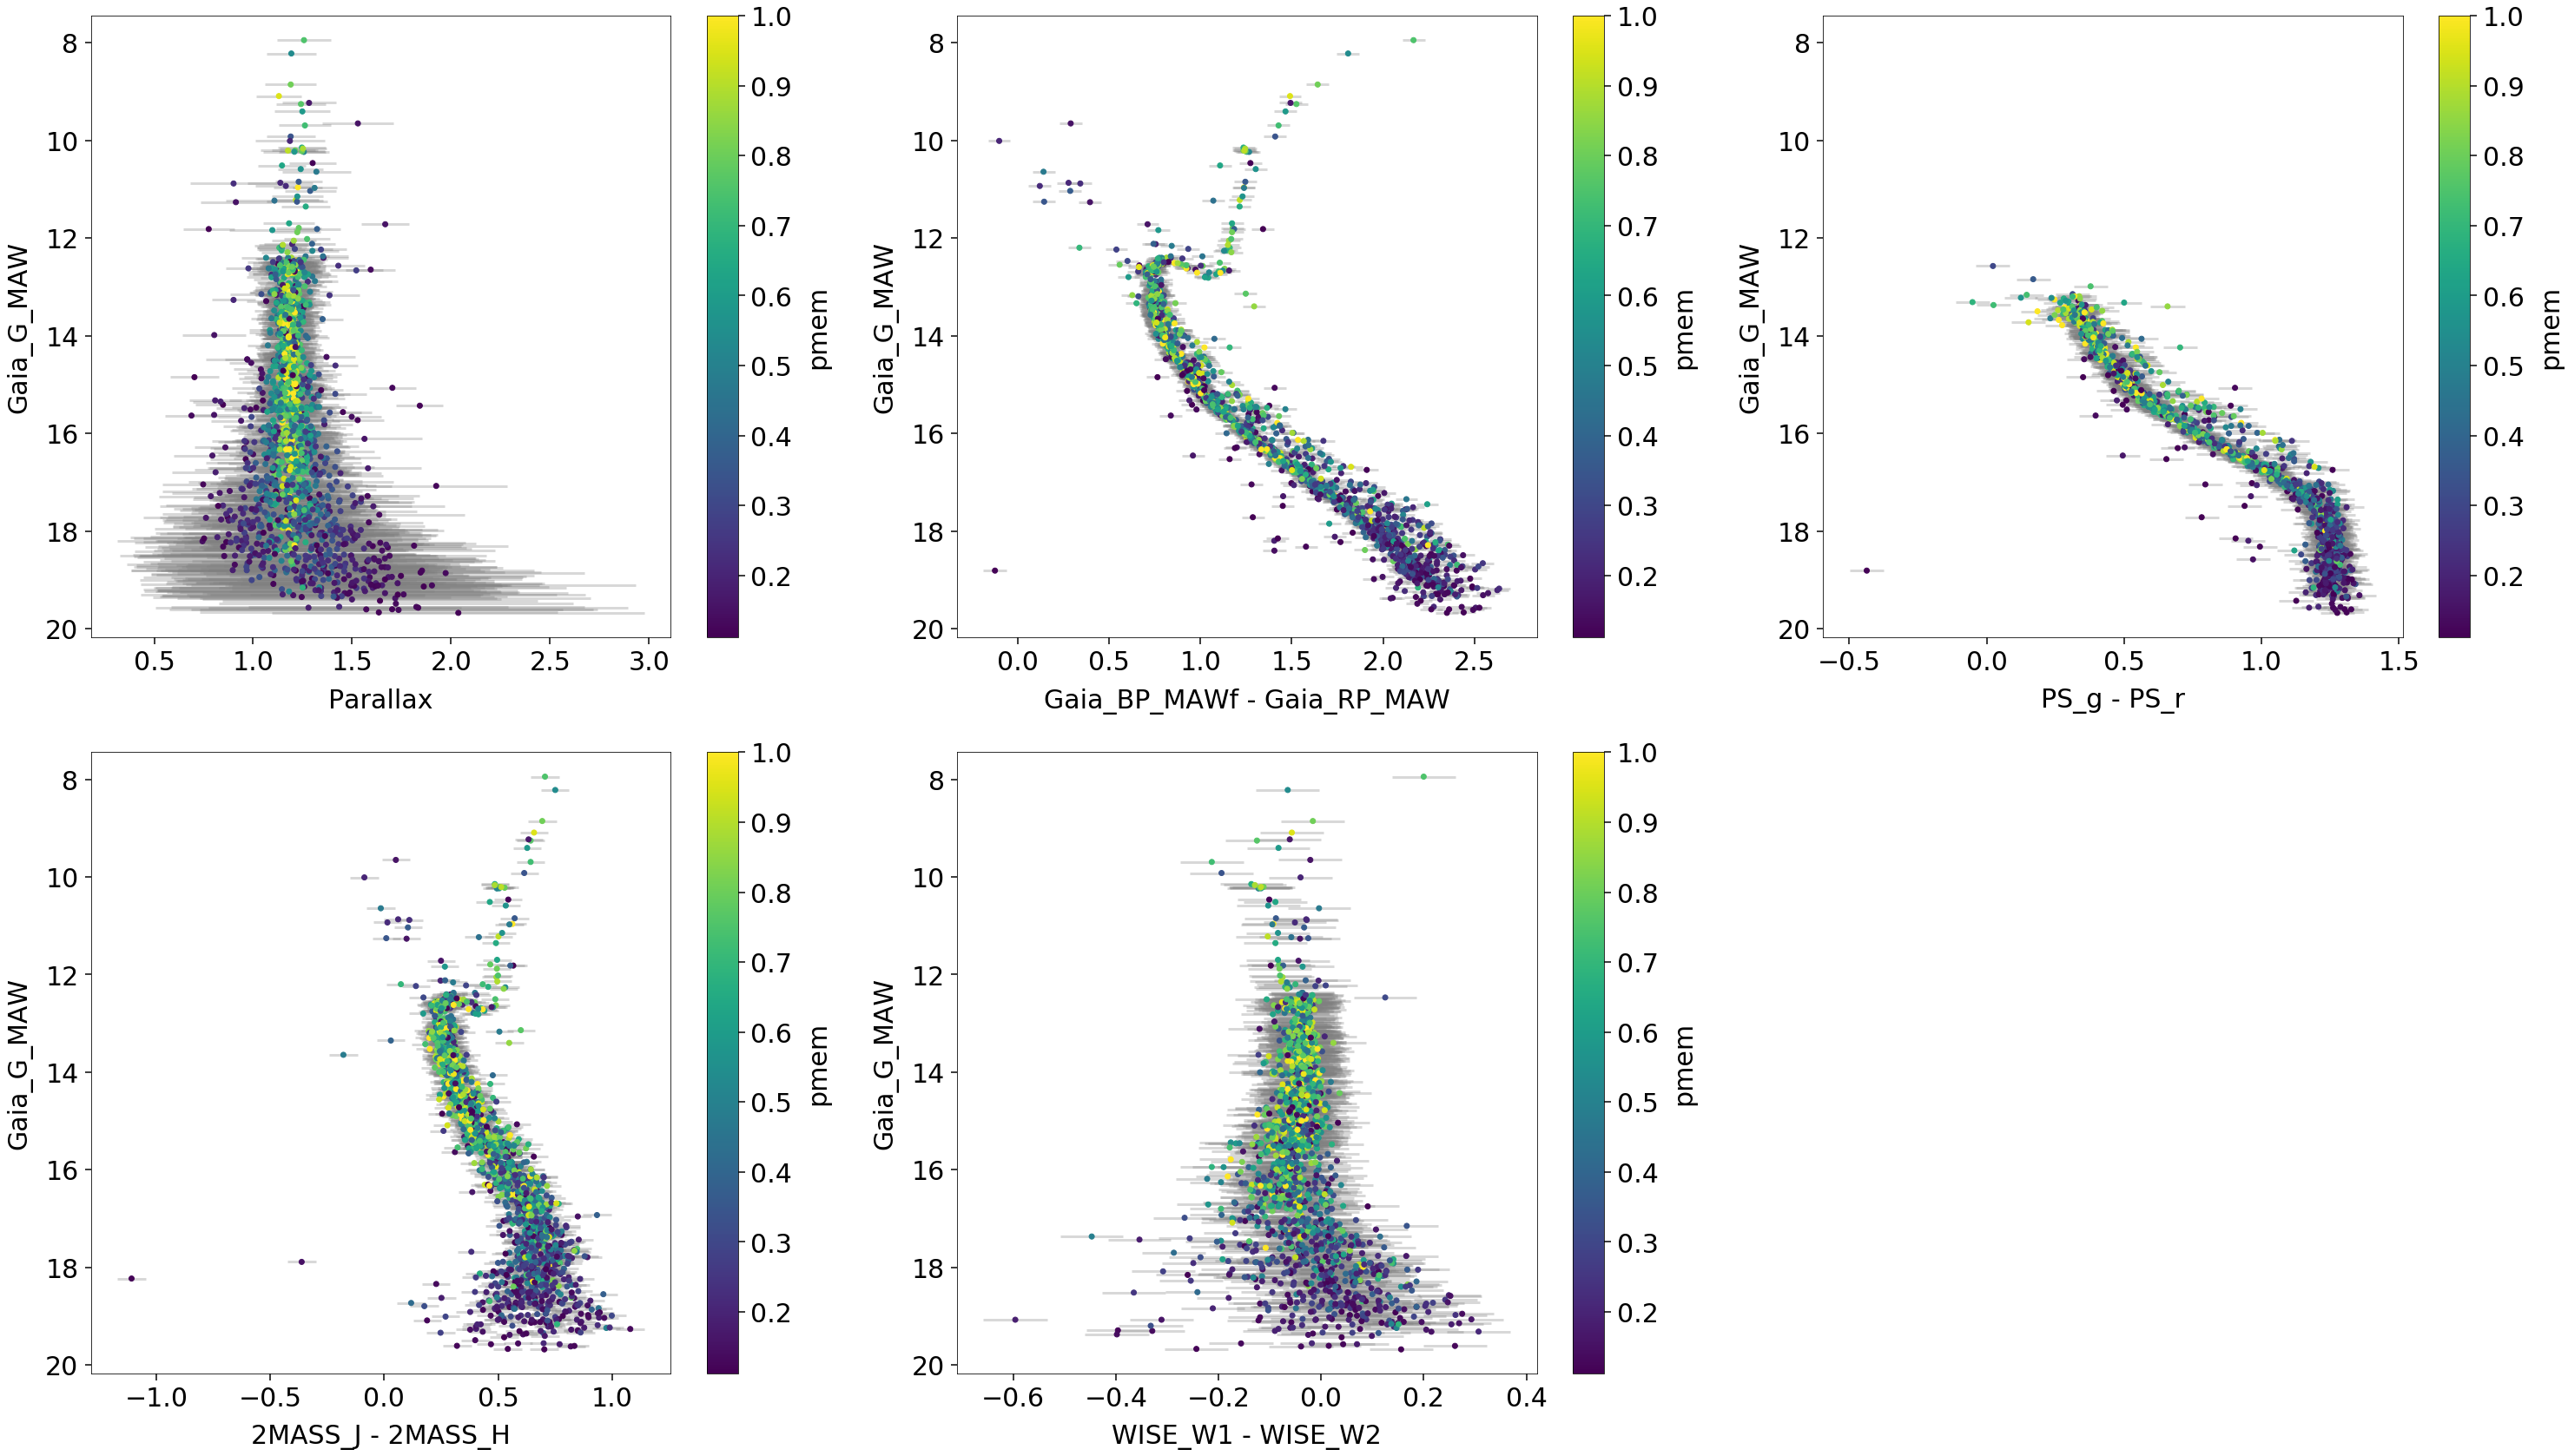

In [8]:
plot_cmds(phot, err, info, parallax, parallax_err)

Due to discrepancies between the data and the models at lower masses, it will be helpful to remove the lower-mass end.

In [9]:
sel = -2.5 * np.log10(phot[:, 0]) <= 17  # remove sources with G > 17

phot, err, mask = phot[sel], err[sel], mask[sel]
parallax, parallax_err = parallax[sel], parallax_err[sel]
info = info[sel]

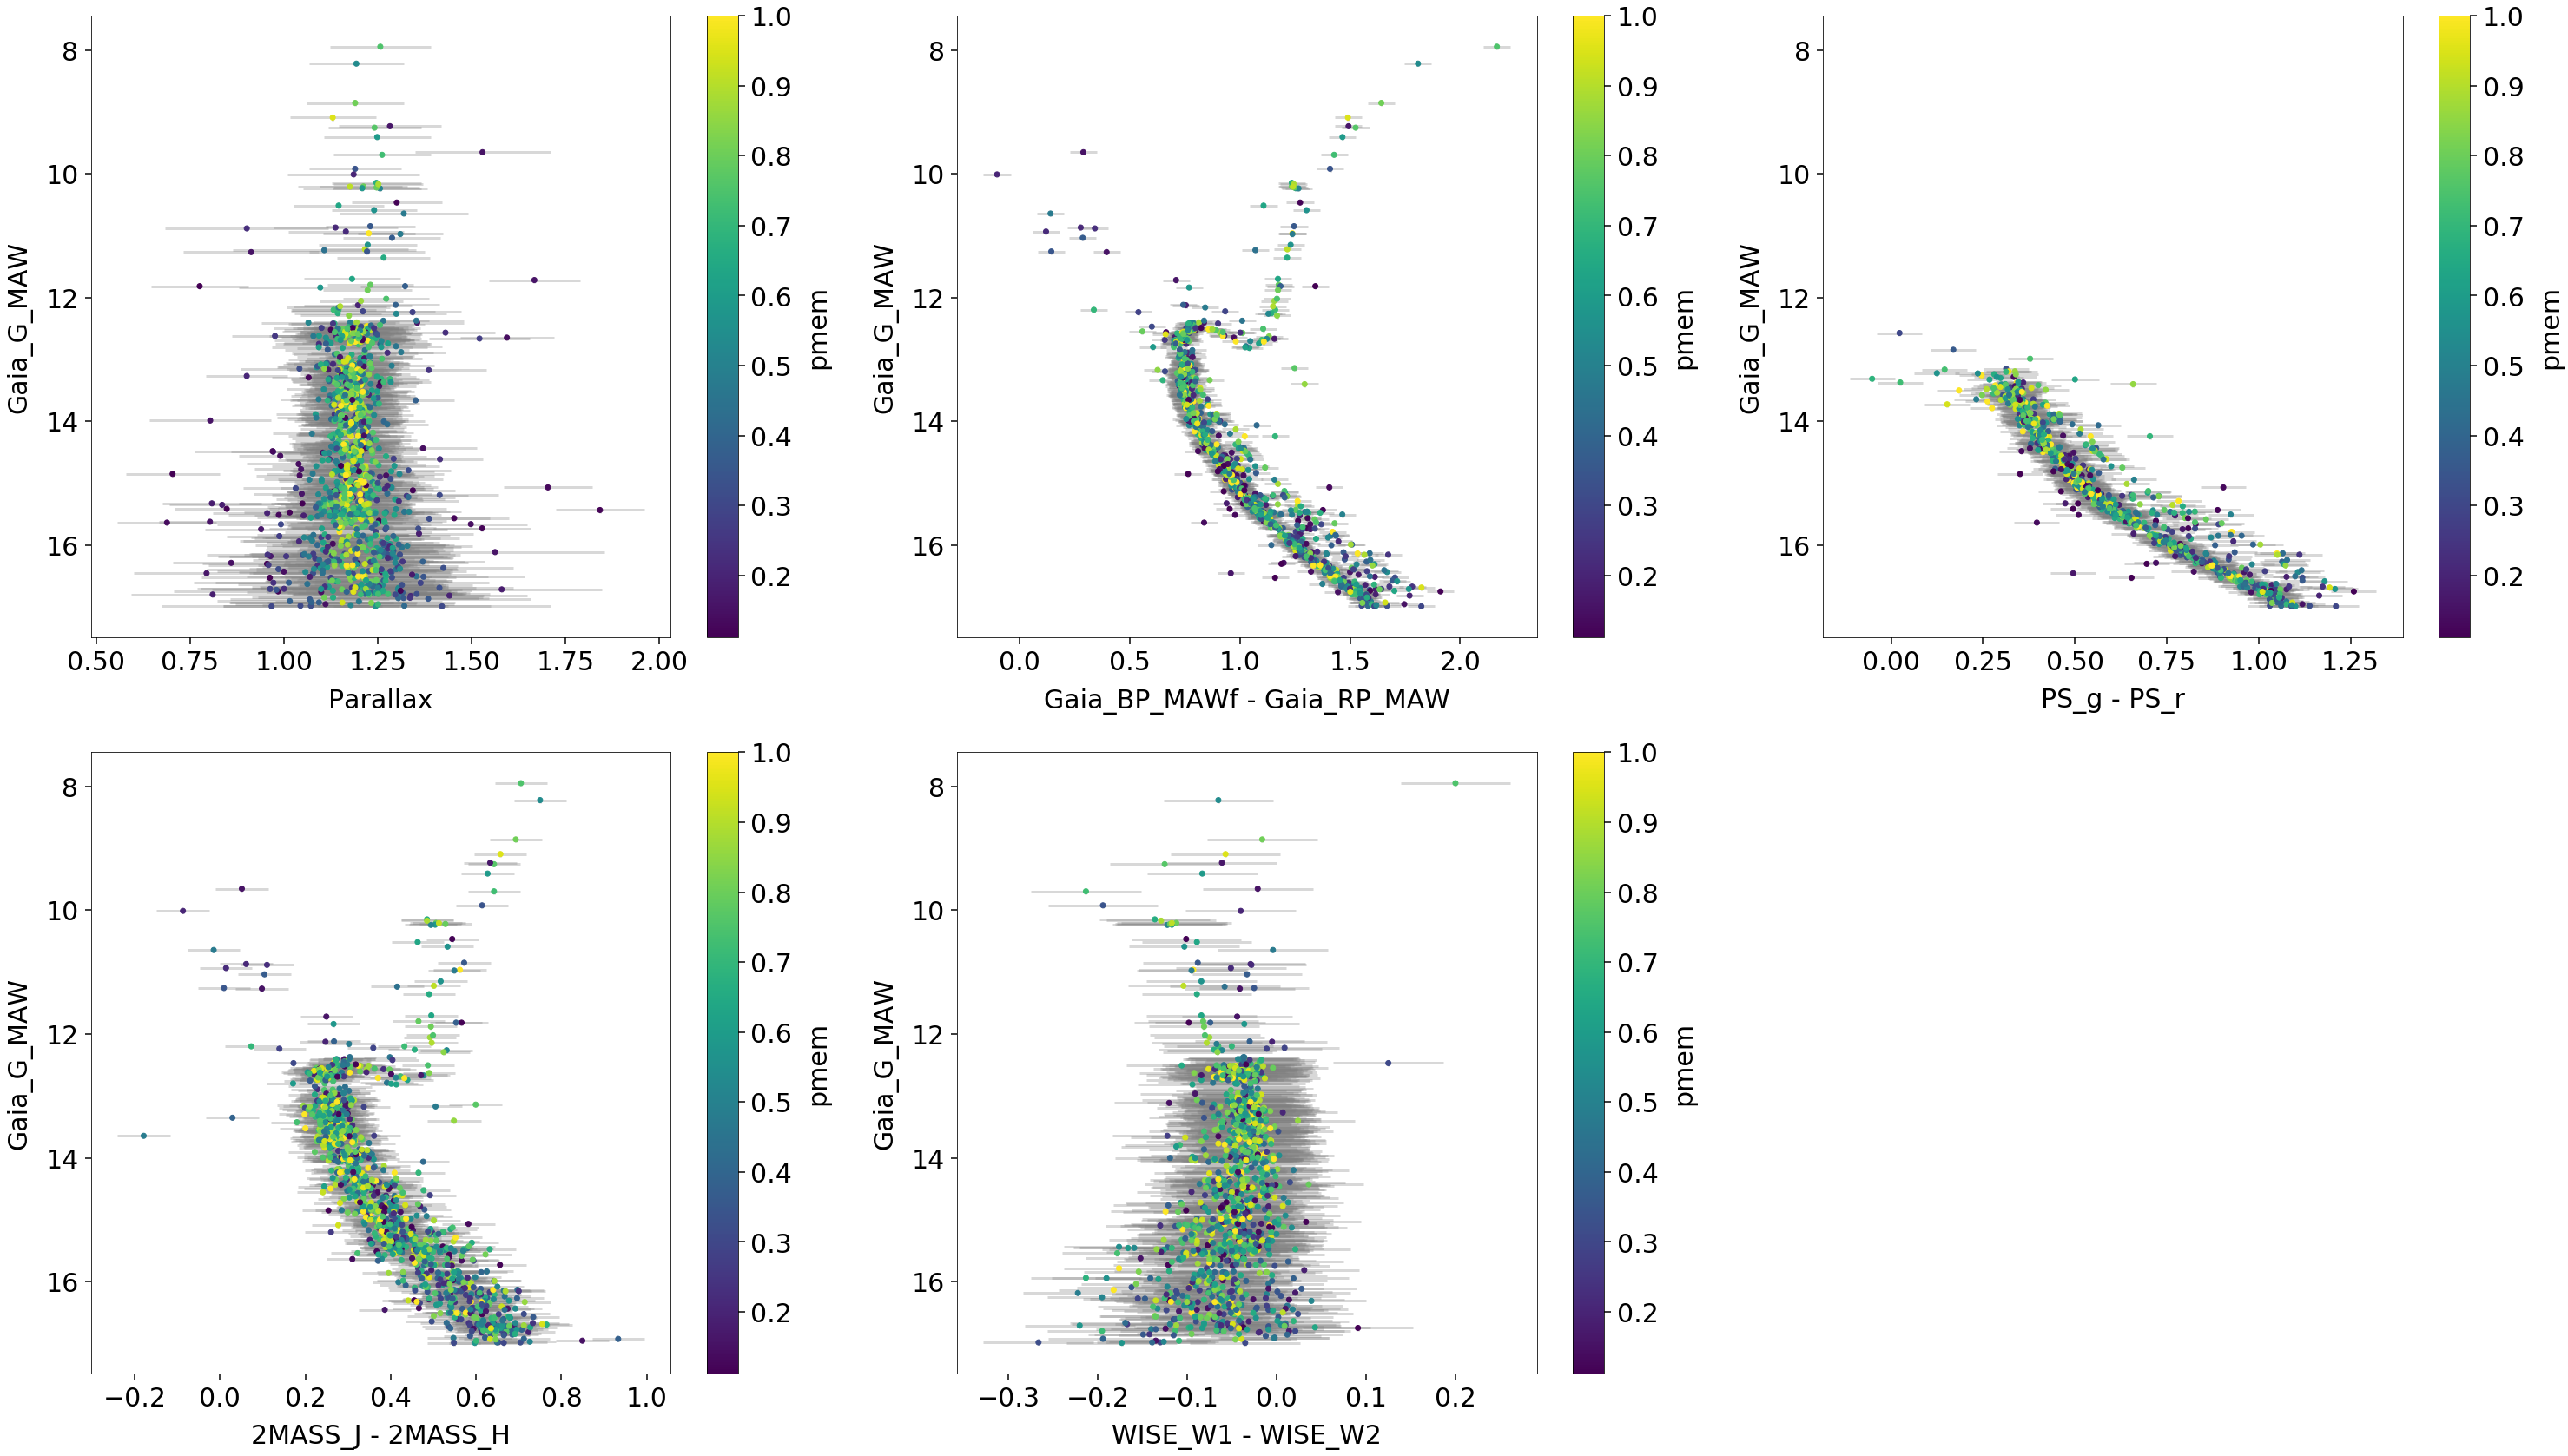

In [10]:
plot_cmds(phot, err, info, parallax, parallax_err)

# Model

The bulk of the cluster model is incorporated into the `cluster` module through the `isochrone_loglike` function. This has a lot of moving pieces, as outlined in Speagle et al. (2020b) and the documentation, so we'll go through them one piece at a time.

In [11]:
from brutus.cluster import isochrone_loglike as loglike

help(loglike)

Help on function isochrone_loglike in module brutus.cluster:

isochrone_loglike(theta, isochrone, phot, err, cluster_params='free', offsets='fixed', corr_params='fixed', mini_bound=0.08, eep_binary_max=480.0, smf_grid=None, eep_grid=None, parallax=None, parallax_err=None, cluster_prob=0.95, dim_prior=True, return_lnls=False)
    Compute the log-likelihood for a given co-eval stellar population
    based on the given isochrone parameters `theta`. Assumes a uniform
    outlier model in distance and parallax.
    
    Parameters
    ----------
    theta : `~numpy.ndarray` of shape `(Nparams,)`
        A collection of parameters used to compute the cluster model.
        The full collection of parameters that can be modeled includes three
        sets of parameters. The first are the parameters related to
        the **physical cluster properties**.
        The second are the **"offsets"** in each band (i.e. what the
        data need to be multiplied by to agree with the models).
        

## Baseline

The baseline cluster model involves fitting for 6 cluster parameters: metallicity (`feh`), log(age) (`loga`), extinction in A(V) (`av`), shape of the reddening curve in R(V) (`rv`), the distance to the cluster in pc (`dist`), and the outlier fraction (`fout`).

The fit marginalizes over EEP (i.e. initial mass) and secondary mass fraction (i.e. binarity) using grids in both parameters to derive the marginal likelihood over all objects in the cluster. The exact parameters of the isochrone itself depend on the first five parameters. The sixth parameter is used to model the fraction of stars that are outliers using a simple (flat) outlier model. This is functionally equivalent to having the likelihood hit a minimum "floor" at some (low) value, which we take to occur at the point when there is less that a $10^-5$ chance that the measured $\chi^2_n$ value in $n$ bands is as large as the observed value, where $n$ can vary per object.

We will first start out with an initial guess, compute the log-likelihood, and overplot the results.

In [12]:
dist_gaia = 1e3 / np.average(info['parallax'], 
                        weights=info['pmem']/info['parallax_err']**2)

# initial parameters
feh = 0.05
loga = 9.55
av = 0.13
rv = 3.3
dist = dist_gaia
fout = 0.015
theta = np.array([feh, loga, av, rv, dist, fout])

# generate isochrone
eep_grid = np.linspace(202, 808, 2000)
smf_grid = np.array([0., 0.2, 0.35, 0.45, 0.5, 0.55, 0.6, 0.65,
                     0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
mags = []
for smf in smf_grid:
    mags.append(iso.get_seds(feh=feh, loga=loga, smf=smf,
                             av=av, rv=rv, eep=eep_grid,
                             dist=dist)[0])

In [13]:
# get log-likelihood given cluster params
lnl, lnls = loglike(theta, iso, phot, err,
                    parallax=parallax, parallax_err=parallax_err,
                    return_lnls=True)  # return individual log-likelihoods

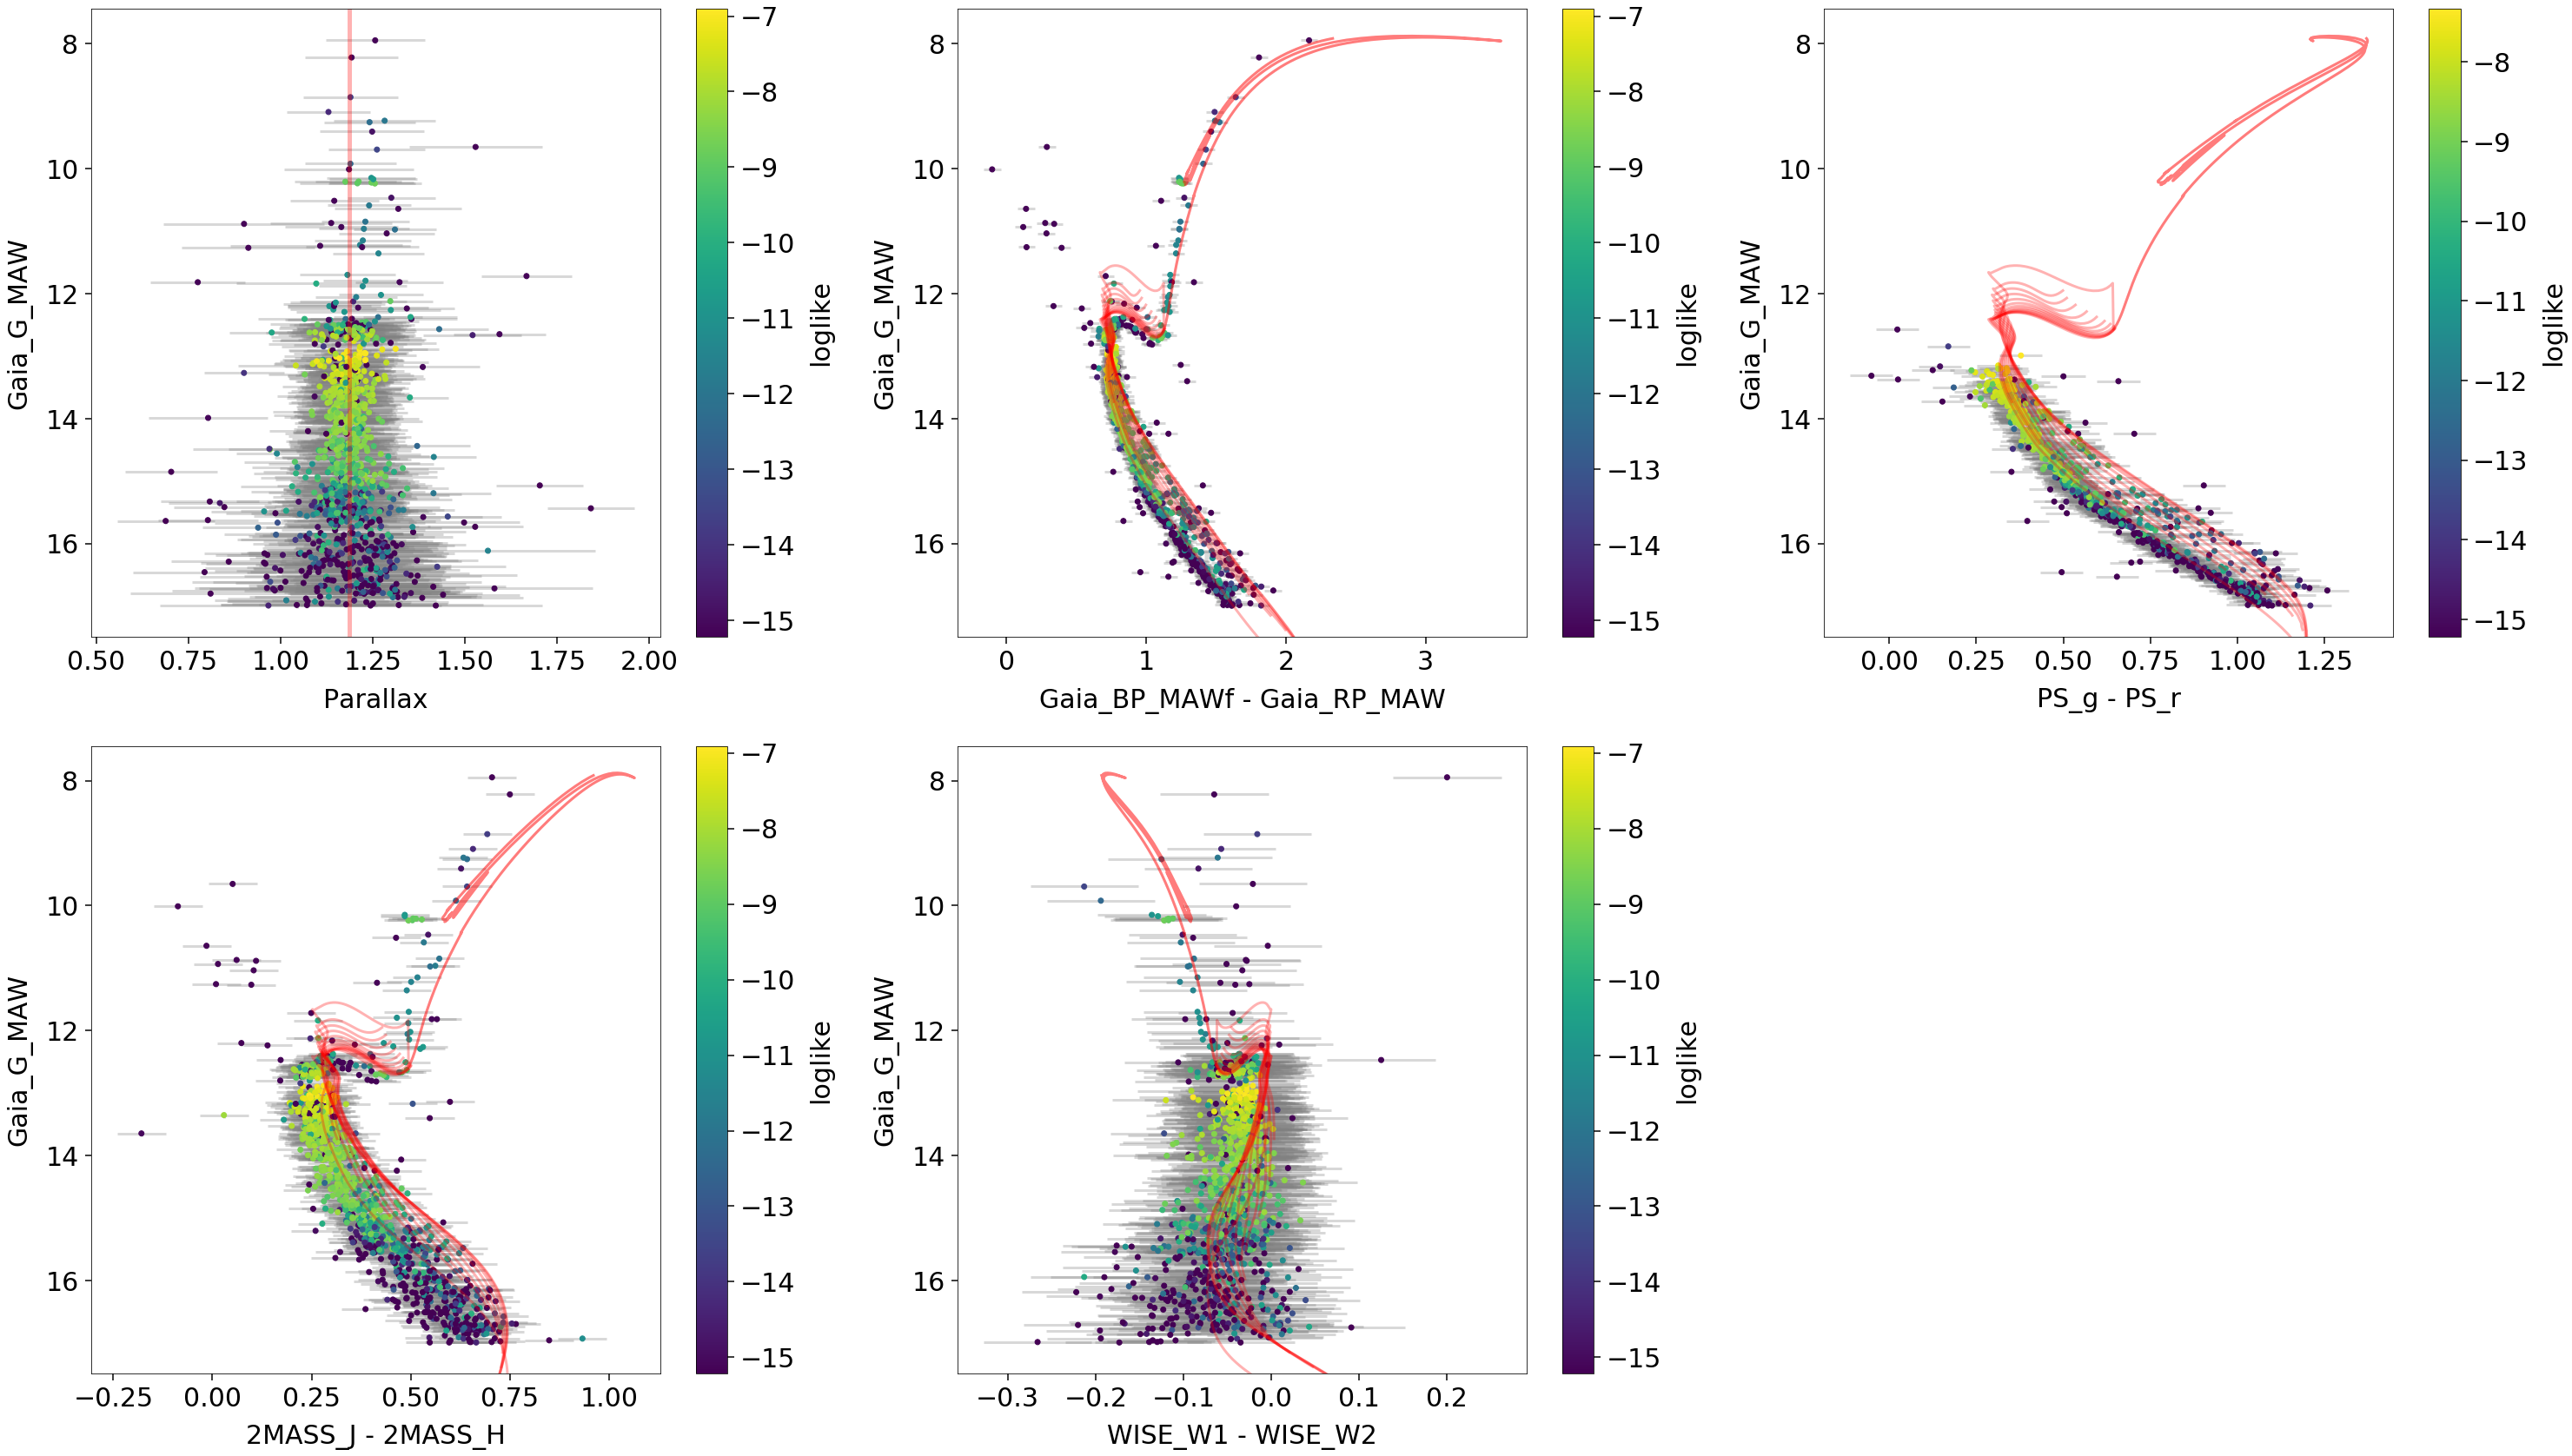

In [14]:
# plot results
plot_cmds(phot, err, info, parallax, parallax_err,
          iso_mags=mags, dist=dist, lnls=lnls)

Let's now try to see if we can find a better fit using the `minimize` function from `scipy.optimize`.

In [15]:
from scipy.optimize import minimize

global lnl_max
lnl_max = -1e300

def negloglike(theta):
    
    # get loglikelihood
    lnl_new = loglike(theta, iso, phot, err,
                      parallax=parallax, parallax_err=parallax_err,
                      cluster_params='free')  # sample cluster params

    # only print out value if we improve
    global lnl_max
    if lnl_new > lnl_max:
        lnl_max = lnl_new
        print('ln(L):', lnl_max)
        print('theta:', np.round(theta, 3))
    
    return -lnl_new

results = minimize(negloglike, theta, method='powell')

ln(L): -11731.616468065917
theta: [5.00000e-02 9.55000e+00 1.30000e-01 3.30000e+00 8.42608e+02 1.50000e-02]
ln(L): -11490.039361772702
theta: [-7.80000e-02  9.55000e+00  1.30000e-01  3.30000e+00  8.42608e+02
  1.50000e-02]
ln(L): -11481.079946071593
theta: [-5.70000e-02  9.55000e+00  1.30000e-01  3.30000e+00  8.42608e+02
  1.50000e-02]
ln(L): -11480.84644467694
theta: [-5.80000e-02  9.55000e+00  1.30000e-01  3.30000e+00  8.42608e+02
  1.50000e-02]
ln(L): -11480.813507904079
theta: [-6.00000e-02  9.55000e+00  1.30000e-01  3.30000e+00  8.42608e+02
  1.50000e-02]
ln(L): -11369.557781851396
theta: [-6.00000e-02  9.59600e+00  1.30000e-01  3.30000e+00  8.42608e+02
  1.50000e-02]
ln(L): -11304.322084424486
theta: [-6.00000e-02  9.61700e+00  1.30000e-01  3.30000e+00  8.42608e+02
  1.50000e-02]
ln(L): -11293.55751802281
theta: [-6.00000e-02  9.62700e+00  1.30000e-01  3.30000e+00  8.42608e+02
  1.50000e-02]
ln(L): -11293.33444688053
theta: [-6.00000e-02  9.62800e+00  1.30000e-01  3.30000e+00  8.

ln(L): -10781.32052240461
theta: [-5.20000e-02  9.57100e+00  1.75000e-01  4.09600e+00  8.84559e+02
  1.20000e-01]
ln(L): -10781.319591615673
theta: [-5.20000e-02  9.57100e+00  1.75000e-01  4.09200e+00  8.84559e+02
  1.20000e-01]
ln(L): -10781.021035201822
theta: [-5.20000e-02  9.57100e+00  1.75000e-01  4.09200e+00  8.85559e+02
  1.20000e-01]
ln(L): -10781.015168743492
theta: [-5.20000e-02  9.57100e+00  1.75000e-01  4.09200e+00  8.85438e+02
  1.20000e-01]
ln(L): -10780.537418877671
theta: [-5.30000e-02  9.56800e+00  1.77000e-01  4.10400e+00  8.86012e+02
  1.19000e-01]
ln(L): -10779.952082297405
theta: [-5.30000e-02  9.56600e+00  1.78000e-01  4.11000e+00  8.86324e+02
  1.18000e-01]
ln(L): -10779.941291398263
theta: [-5.30000e-02  9.56600e+00  1.79000e-01  4.11100e+00  8.86341e+02
  1.18000e-01]
ln(L): -10779.936280794369
theta: [-5.30000e-02  9.56600e+00  1.79000e-01  4.11100e+00  8.86369e+02
  1.18000e-01]
ln(L): -10779.936001795897
theta: [-5.3000e-02  9.5660e+00  1.7900e-01  4.1110e+0

It looks like fit has improved, so let's see how we did!

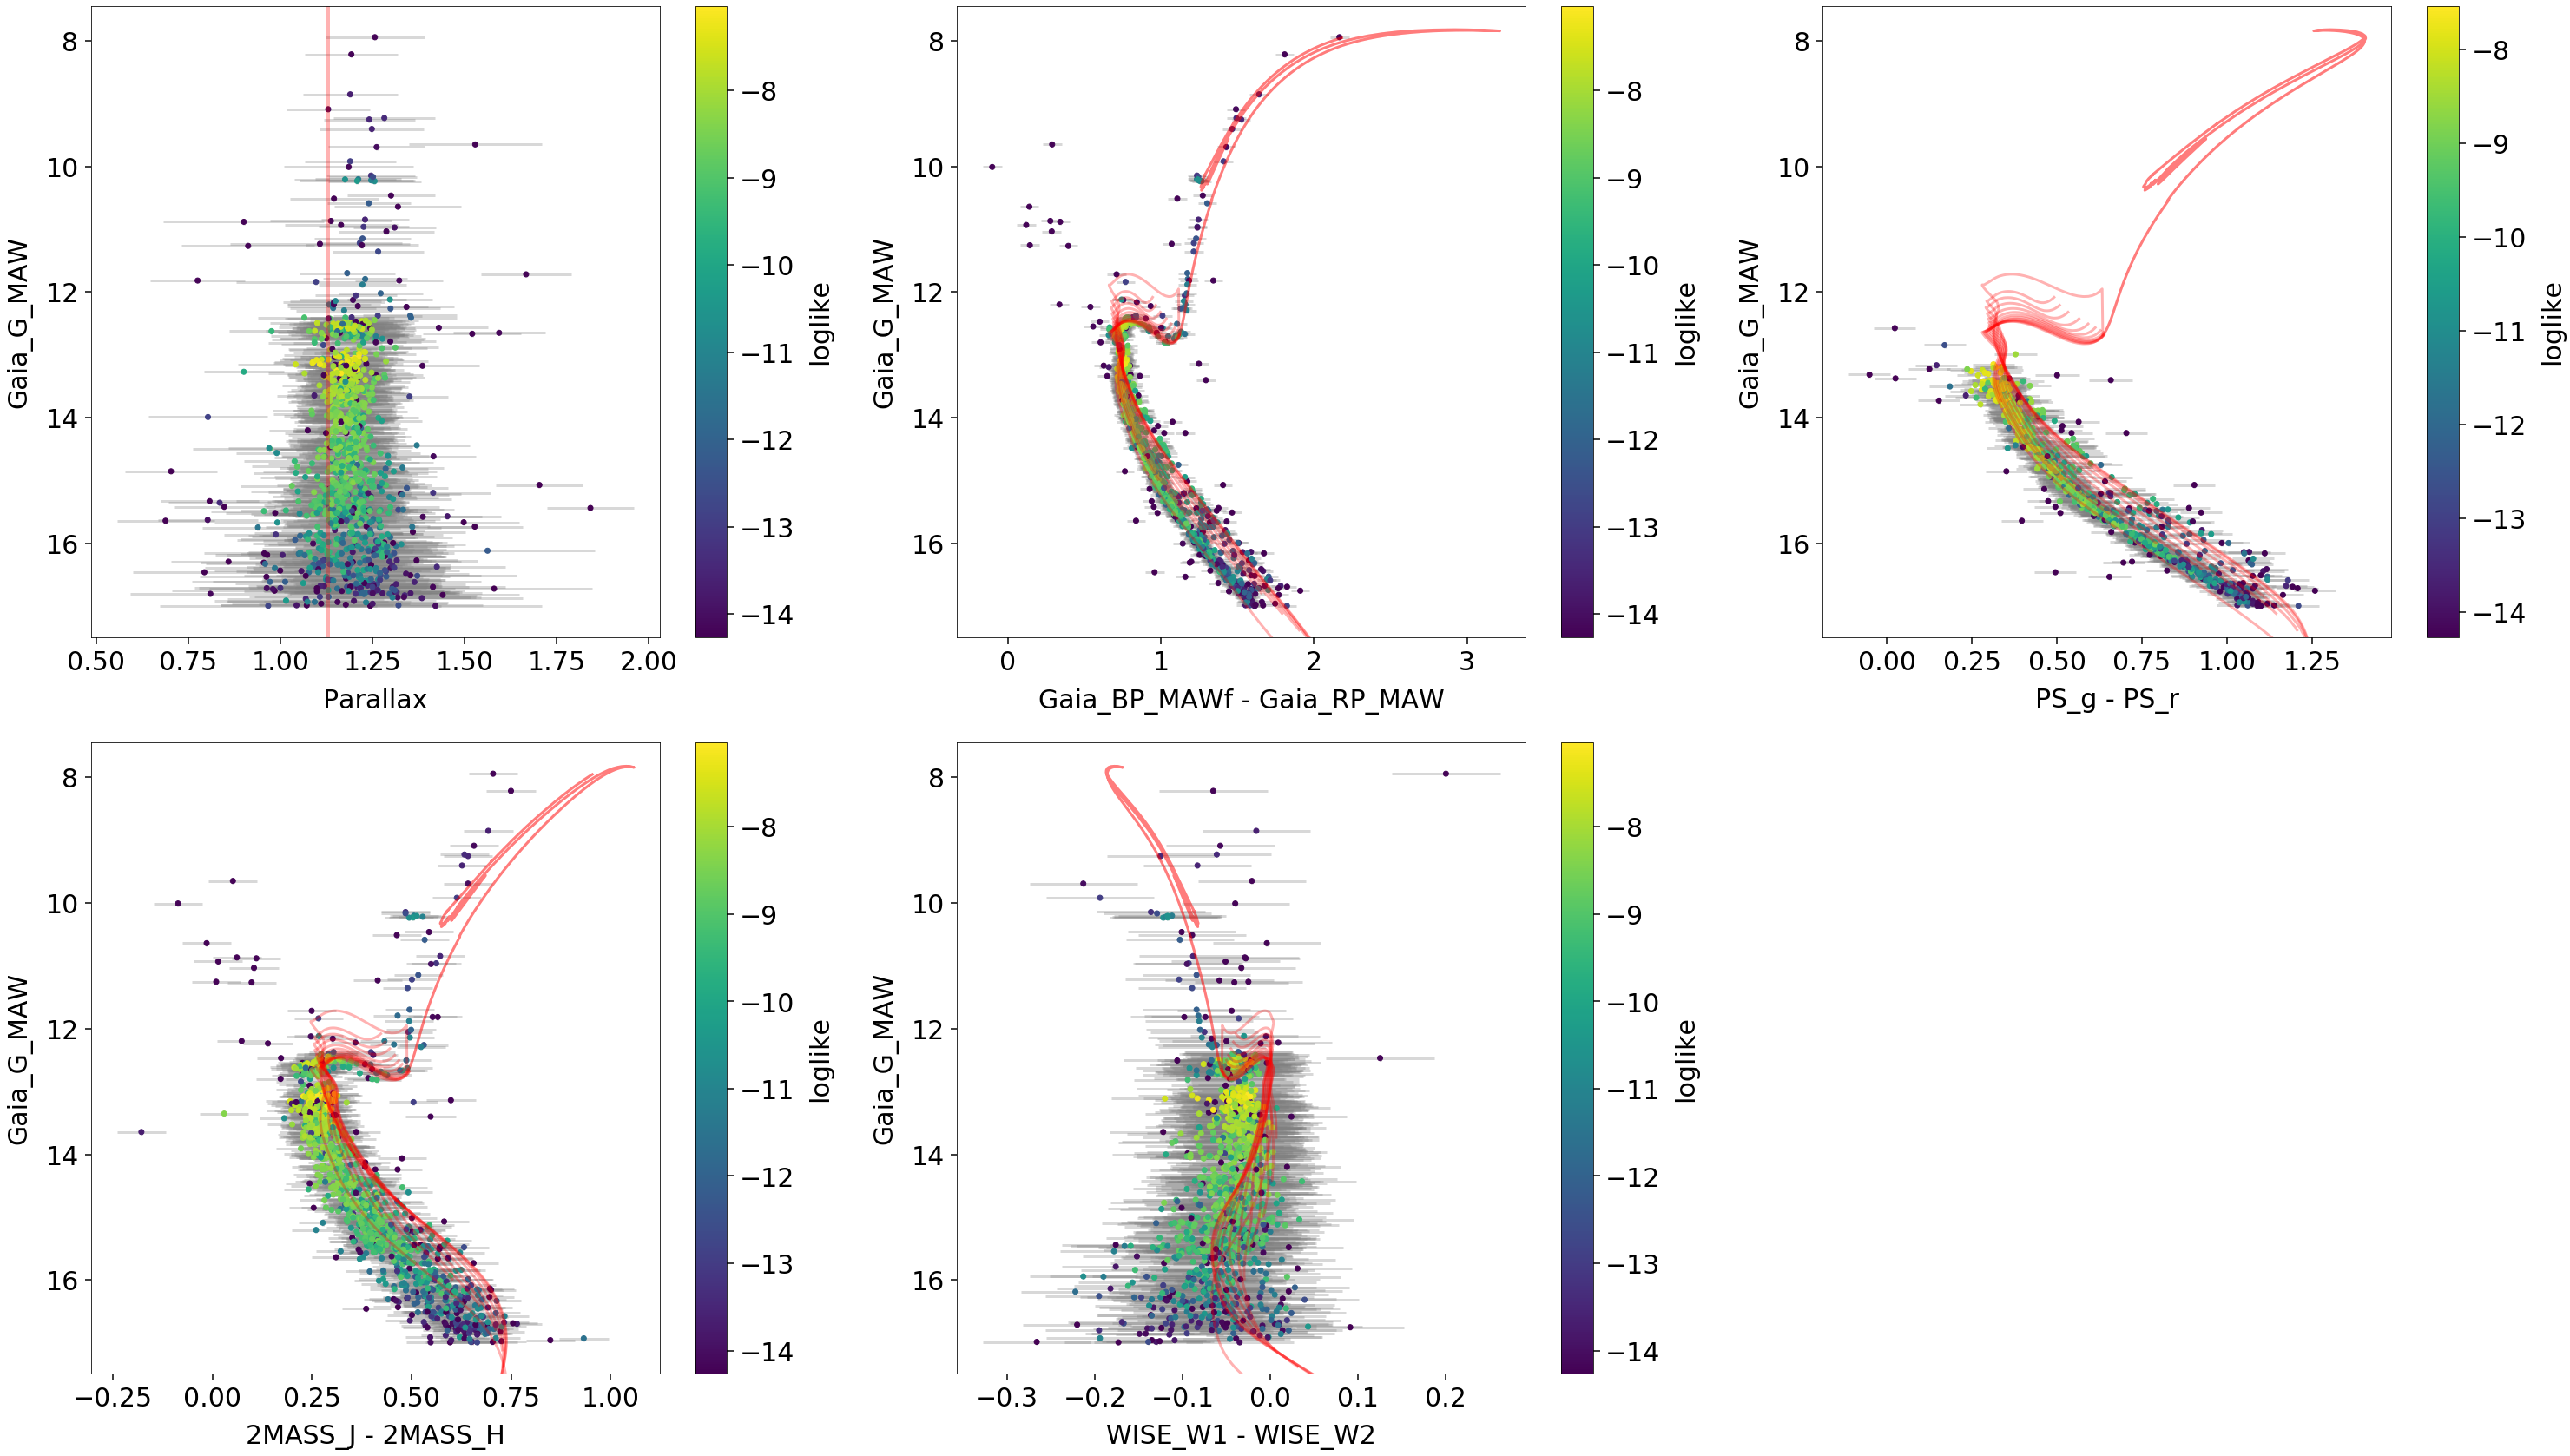

In [16]:
# new parameters
theta = results['x']
feh, loga, av, rv, dist, fout = theta

# new likelihoods
lnl, lnls = loglike(theta, iso, phot, err,
                    parallax=parallax, parallax_err=parallax_err,
                    cluster_params='free',
                    return_lnls=True)

# new isochrones
mags = []
for smf in smf_grid:
    mags.append(iso.get_seds(feh=feh, loga=loga, smf=smf,
                             av=av, rv=rv, eep=eep_grid,
                             dist=dist)[0])

# plot results
plot_cmds(phot, err, info, parallax, parallax_err,
          iso_mags=mags, dist=dist, lnls=lnls)

That's good overall, but a little worrisome. Apparently, the fit is happy to shift the distance for all objects in order to get a substantially better fit to the SEDs at lower masses.

## Photometric Offsets

This baseline model can be modified by allowing for the modeling of **photometric offsets**. These are a set of $n$ nuisance parameters, one for each band, that allows the photometry in that band to be scaled in flux (i.e. shifted in magnitudes) by an unknown amount. This can allow the isochrone to shift around in individual CMDs without requiring it to also shift in distance. Given the large number of objects with parallaxes ($>1000$) here, this can be used to derive mean offsets in each band subject to degeneracies in distance, metallicity, and/or reddening.

In [24]:
from brutus import utils as butils

# initial offsets
offsets = butils.load_offsets('../data/DATAFILES/offsets_mist_v8.txt', 
                              filters=flt_list)

Gaia_G_MAW (1.0%)
Gaia_BP_MAWf (2.0%)
Gaia_RP_MAW (-3.0%)
PS_g (0.0%)
PS_r (-3.0%)
PS_i (-3.0%)
PS_z (-2.0%)
PS_y (-4.0%)
2MASS_J (-2.0%)
2MASS_H (1.0%)
2MASS_Ks (-2.0%)
WISE_W1 (2.0%)
WISE_W2 (3.0%)


Adding this into the model just requires that we set the `offsets` argument in the log-likelihood to be `'free'` rather than `'fixed'` (the default). Now when we pass `theta`, the log-likelihood expects us to pass both a set of cluster parameters and photometric offsets.

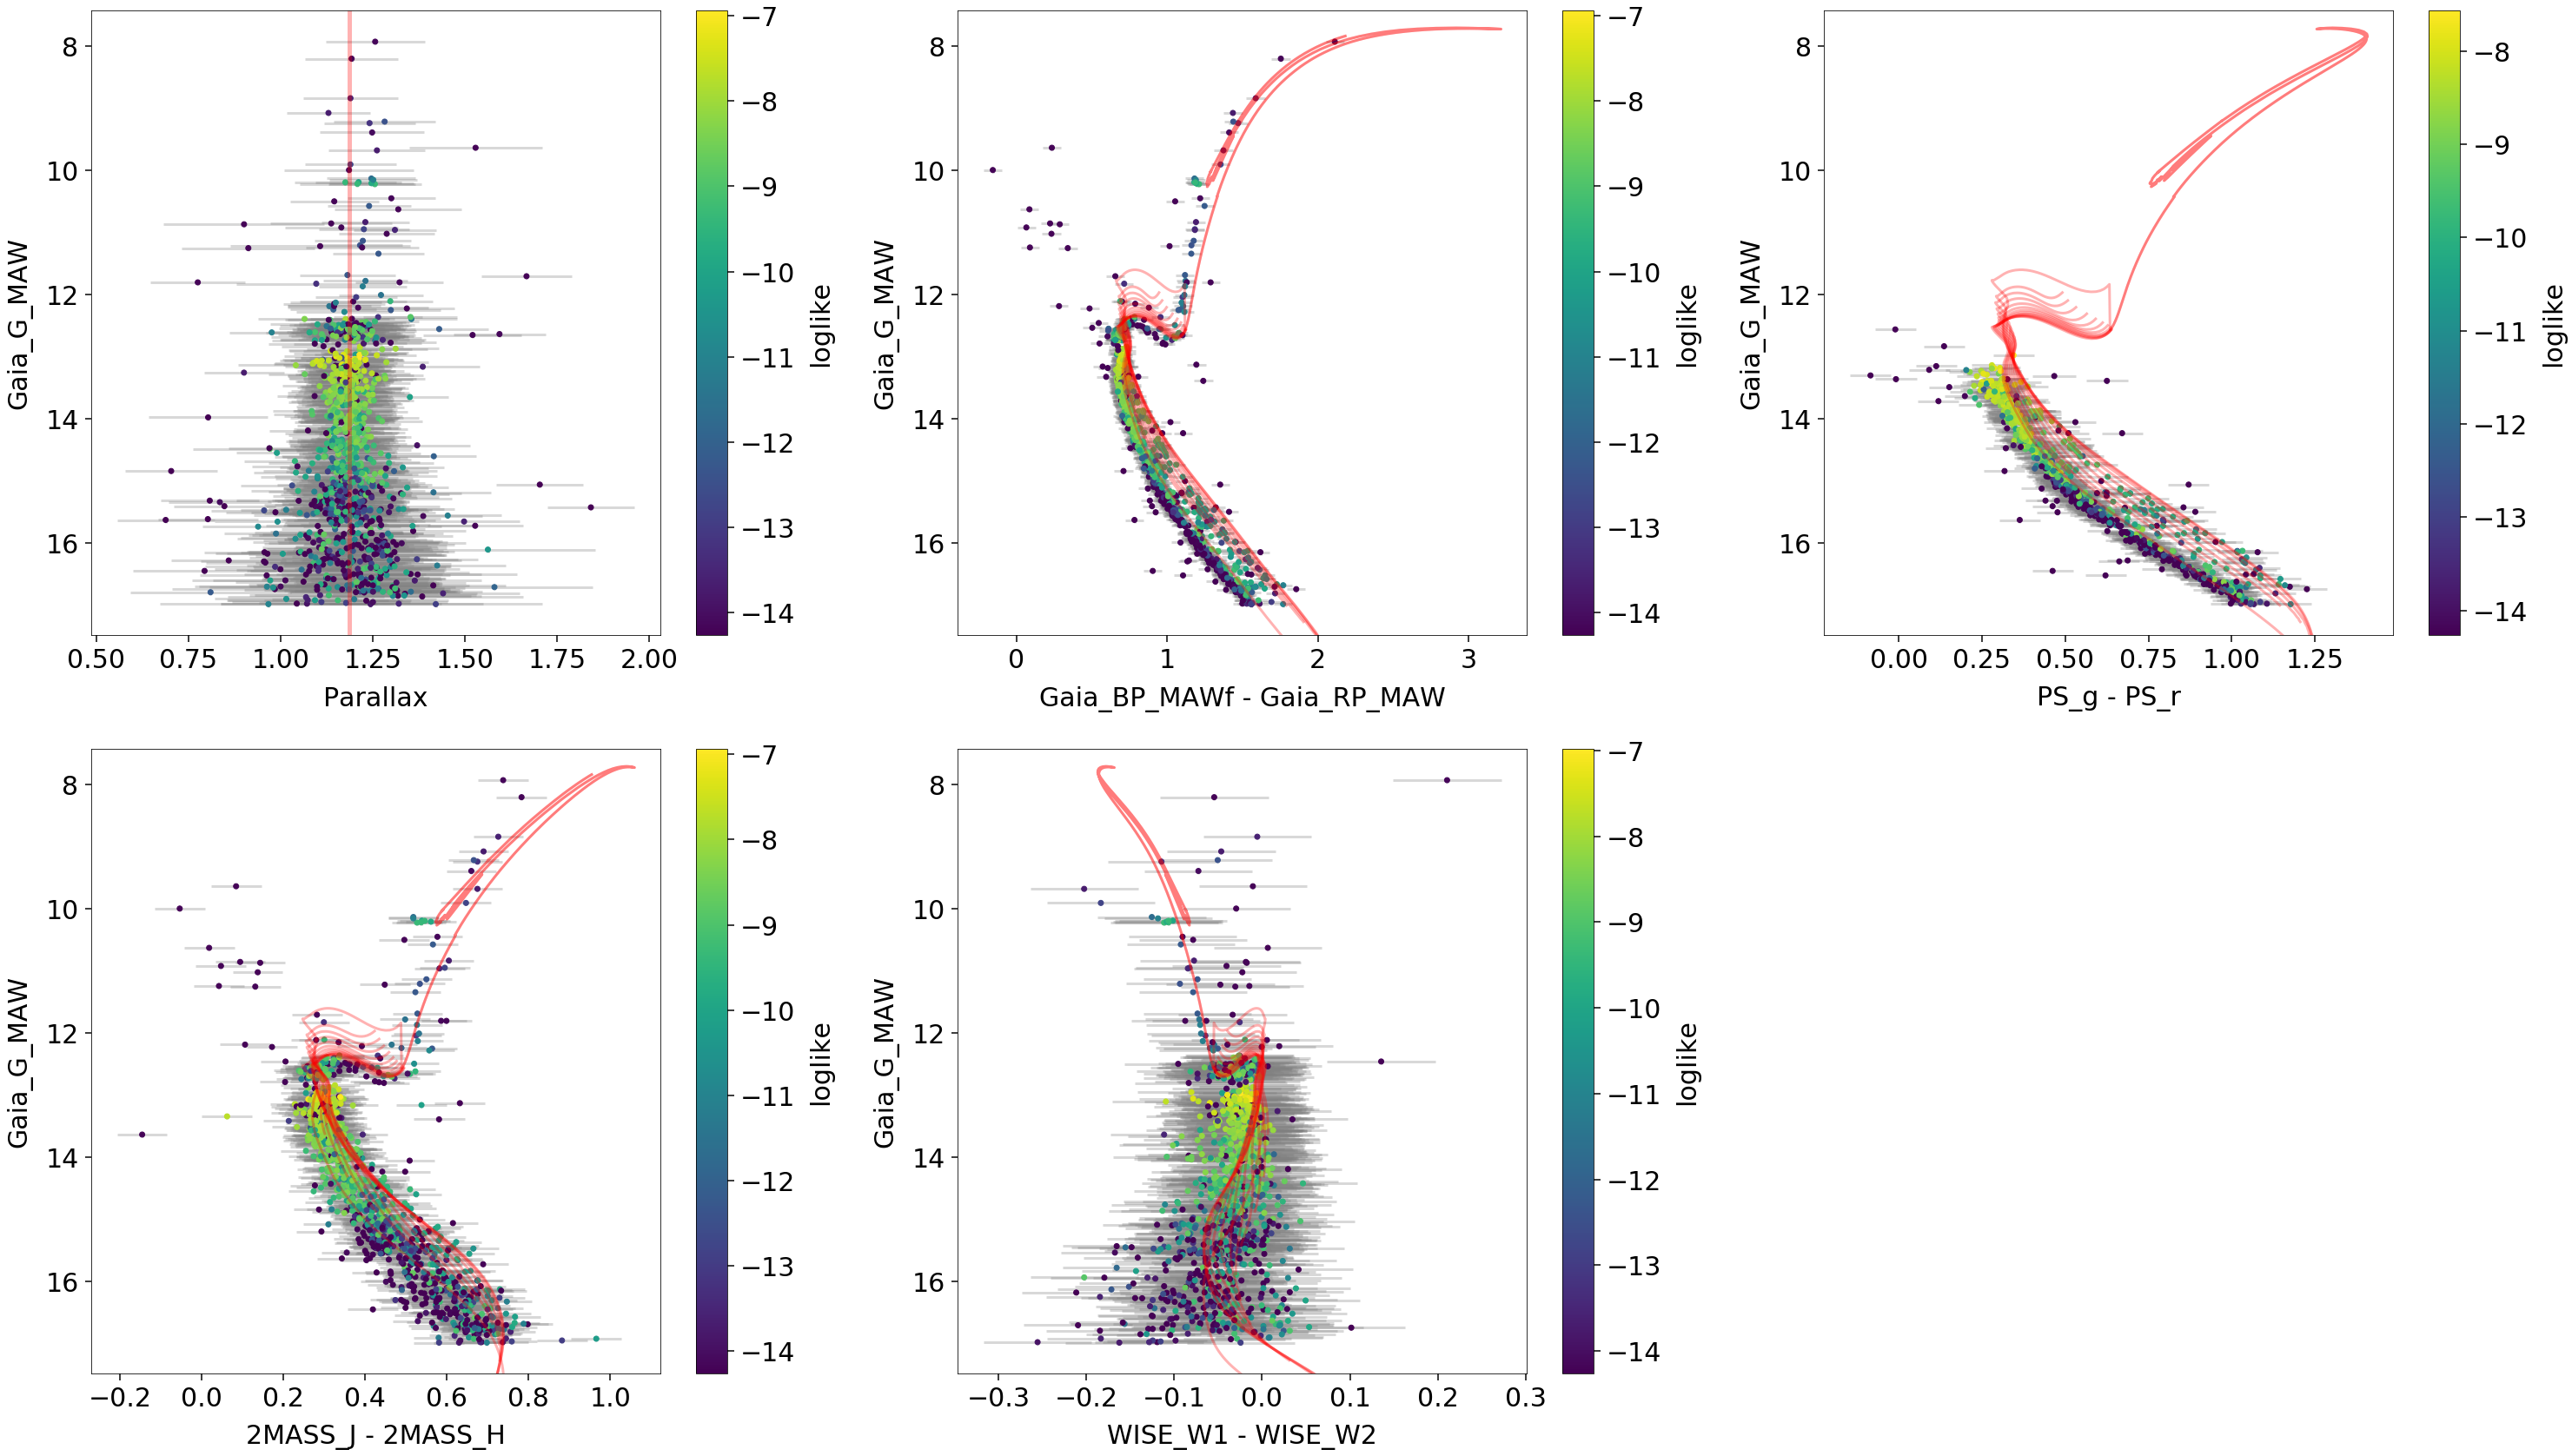

In [28]:
# combine
theta = np.append([feh, loga, av, rv, dist_gaia, fout], offsets)
feh, loga, av, rv, dist, fout = theta[:6]

# new likelihoods
lnl, lnls = loglike(theta, iso, phot, err,
                    parallax=parallax, parallax_err=parallax_err,
                    cluster_params='free', offsets='free',
                    return_lnls=True)

# new isochrones
mags = []
for smf in smf_grid:
    mags.append(iso.get_seds(feh=feh, loga=loga, smf=smf,
                             av=av, rv=rv, eep=eep_grid,
                             dist=dist)[0])

# plot results
plot_cmds(phot, err, info, parallax, parallax_err,
          iso_mags=mags, dist=dist, lnls=lnls,
          offsets=offsets)

As expected, the best-fit model excluding photometric offsets (with the distance shifted back into agreement with *Gaia*) is not a great fit to the photometry after including possible photometric offsets. We can, however, attempt to find a better model the same way as before.

In [29]:
from scipy.optimize import minimize

global lnl_max
lnl_max = -1e300

def negloglike(theta):
    
    # get loglikelihood
    lnl_new = loglike(theta, iso, phot, err,
                      parallax=parallax, parallax_err=parallax_err,
                      cluster_params='free', offsets='free')

    # only print out value if we improve
    global lnl_max
    if lnl_new > lnl_max:
        lnl_max = lnl_new
        print('ln(L):', lnl_max)
        print('theta:', np.round(theta, 3))
    
    return -lnl_new

results = minimize(negloglike, theta, method='powell')

ln(L): -11614.301428535571
theta: [-5.10000e-02  9.56400e+00  1.83000e-01  3.99900e+00  8.42608e+02
  1.23000e-01  1.01000e+00  1.02000e+00  9.70000e-01  1.00000e+00
  9.70000e-01  9.70000e-01  9.80000e-01  9.60000e-01  9.80000e-01
  1.01000e+00  9.80000e-01  1.02000e+00  1.03000e+00]
ln(L): -10720.293942739494
theta: [-3.10000e-01  9.56400e+00  1.83000e-01  3.99900e+00  8.42608e+02
  1.23000e-01  1.01000e+00  1.02000e+00  9.70000e-01  1.00000e+00
  9.70000e-01  9.70000e-01  9.80000e-01  9.60000e-01  9.80000e-01
  1.01000e+00  9.80000e-01  1.02000e+00  1.03000e+00]
ln(L): -10594.159176668403
theta: [-2.55000e-01  9.56400e+00  1.83000e-01  3.99900e+00  8.42608e+02
  1.23000e-01  1.01000e+00  1.02000e+00  9.70000e-01  1.00000e+00
  9.70000e-01  9.70000e-01  9.80000e-01  9.60000e-01  9.80000e-01
  1.01000e+00  9.80000e-01  1.02000e+00  1.03000e+00]
ln(L): -10582.439265788209
theta: [-2.42000e-01  9.56400e+00  1.83000e-01  3.99900e+00  8.42608e+02
  1.23000e-01  1.01000e+00  1.02000e+00  9

ln(L): -10252.477409513398
theta: [-2.36000e-01  9.64200e+00  1.70000e-01  3.21000e+00  8.56115e+02
  7.10000e-02  1.02600e+00  1.02700e+00  9.70000e-01  1.00000e+00
  9.70000e-01  9.70000e-01  9.80000e-01  9.60000e-01  9.80000e-01
  1.01000e+00  9.80000e-01  1.02000e+00  1.03000e+00]
ln(L): -10252.447309336623
theta: [-2.36000e-01  9.64200e+00  1.70000e-01  3.21000e+00  8.56115e+02
  7.10000e-02  1.02600e+00  1.02700e+00  9.70000e-01  1.00000e+00
  9.70000e-01  9.70000e-01  9.80000e-01  9.60000e-01  9.80000e-01
  1.01000e+00  9.80000e-01  1.02000e+00  1.03000e+00]
ln(L): -10252.446650655864
theta: [-2.36000e-01  9.64200e+00  1.70000e-01  3.21000e+00  8.56115e+02
  7.10000e-02  1.02600e+00  1.02700e+00  9.70000e-01  1.00000e+00
  9.70000e-01  9.70000e-01  9.80000e-01  9.60000e-01  9.80000e-01
  1.01000e+00  9.80000e-01  1.02000e+00  1.03000e+00]
ln(L): -10219.158672567602
theta: [-2.36000e-01  9.64200e+00  1.70000e-01  3.21000e+00  8.56115e+02
  7.10000e-02  1.02600e+00  1.02700e+00  9

ln(L): -10150.649655904075
theta: [-2.36000e-01  9.64200e+00  1.70000e-01  3.21000e+00  8.56115e+02
  7.10000e-02  1.02600e+00  1.02700e+00  9.85000e-01  1.00900e+00
  9.59000e-01  9.62000e-01  9.72000e-01  9.74000e-01  9.87000e-01
  1.02100e+00  9.94000e-01  1.02000e+00  1.03000e+00]
ln(L): -10107.714559797478
theta: [-2.36000e-01  9.64200e+00  1.70000e-01  3.21000e+00  8.56115e+02
  7.10000e-02  1.02600e+00  1.02700e+00  9.85000e-01  1.00900e+00
  9.59000e-01  9.62000e-01  9.72000e-01  9.74000e-01  9.87000e-01
  1.02100e+00  9.94000e-01  9.82000e-01  1.03000e+00]
ln(L): -10107.558194563895
theta: [-2.36000e-01  9.64200e+00  1.70000e-01  3.21000e+00  8.56115e+02
  7.10000e-02  1.02600e+00  1.02700e+00  9.85000e-01  1.00900e+00
  9.59000e-01  9.62000e-01  9.72000e-01  9.74000e-01  9.87000e-01
  1.02100e+00  9.94000e-01  9.81000e-01  1.03000e+00]
ln(L): -10106.231076117412
theta: [-2.36000e-01  9.64200e+00  1.70000e-01  3.21000e+00  8.56115e+02
  7.10000e-02  1.02600e+00  1.02700e+00  9

ln(L): -10060.910568621735
theta: [-2.21000e-01  9.62400e+00  1.74000e-01  3.16600e+00  8.63444e+02
  5.60000e-02  1.02600e+00  1.02700e+00  9.85000e-01  1.00900e+00
  9.59000e-01  9.62000e-01  9.72000e-01  9.74000e-01  9.87000e-01
  1.02100e+00  9.94000e-01  9.73000e-01  1.00400e+00]
ln(L): -10060.910092284186
theta: [-2.21000e-01  9.62400e+00  1.74000e-01  3.16600e+00  8.63444e+02
  5.60000e-02  1.02600e+00  1.02700e+00  9.85000e-01  1.00900e+00
  9.59000e-01  9.62000e-01  9.72000e-01  9.74000e-01  9.87000e-01
  1.02100e+00  9.94000e-01  9.73000e-01  1.00400e+00]
ln(L): -10059.385882102892
theta: [-2.21000e-01  9.62400e+00  1.74000e-01  3.16600e+00  8.63444e+02
  5.60000e-02  1.03700e+00  1.02700e+00  9.85000e-01  1.00900e+00
  9.59000e-01  9.62000e-01  9.72000e-01  9.74000e-01  9.87000e-01
  1.02100e+00  9.94000e-01  9.73000e-01  1.00400e+00]
ln(L): -10058.070552890933
theta: [-2.21000e-01  9.62400e+00  1.74000e-01  3.16600e+00  8.63444e+02
  5.60000e-02  1.03200e+00  1.02700e+00  9

ln(L): -10055.88345153665
theta: [-2.21000e-01  9.62400e+00  1.74000e-01  3.16600e+00  8.63444e+02
  5.60000e-02  1.03200e+00  1.02800e+00  9.83000e-01  1.01200e+00
  9.61000e-01  9.62000e-01  9.70000e-01  9.73000e-01  9.88000e-01
  1.02300e+00  9.94000e-01  9.73000e-01  1.00400e+00]
ln(L): -10055.754755012993
theta: [-2.21000e-01  9.62400e+00  1.74000e-01  3.16600e+00  8.63444e+02
  5.60000e-02  1.03200e+00  1.02800e+00  9.83000e-01  1.01200e+00
  9.61000e-01  9.62000e-01  9.70000e-01  9.73000e-01  9.88000e-01
  1.02300e+00  9.96000e-01  9.73000e-01  1.00400e+00]
ln(L): -10055.75425152485
theta: [-2.21000e-01  9.62400e+00  1.74000e-01  3.16600e+00  8.63444e+02
  5.60000e-02  1.03200e+00  1.02800e+00  9.83000e-01  1.01200e+00
  9.61000e-01  9.62000e-01  9.70000e-01  9.73000e-01  9.88000e-01
  1.02300e+00  9.96000e-01  9.73000e-01  1.00400e+00]
ln(L): -10055.754249486296
theta: [-2.21000e-01  9.62400e+00  1.74000e-01  3.16600e+00  8.63444e+02
  5.60000e-02  1.03200e+00  1.02800e+00  9.8

ln(L): -10042.711929067984
theta: [-2.07000e-01  9.60900e+00  1.76000e-01  3.07100e+00  8.64655e+02
  5.60000e-02  1.03200e+00  1.02800e+00  9.83000e-01  1.01200e+00
  9.61000e-01  9.62000e-01  9.70000e-01  9.73000e-01  9.88000e-01
  1.02300e+00  9.96000e-01  9.76000e-01  1.00100e+00]
ln(L): -10042.711858726132
theta: [-2.07000e-01  9.60900e+00  1.76000e-01  3.07100e+00  8.64655e+02
  5.60000e-02  1.03200e+00  1.02800e+00  9.83000e-01  1.01200e+00
  9.61000e-01  9.62000e-01  9.70000e-01  9.73000e-01  9.88000e-01
  1.02300e+00  9.96000e-01  9.76000e-01  1.00100e+00]
ln(L): -10042.604872379703
theta: [-2.07000e-01  9.60900e+00  1.76000e-01  3.07100e+00  8.64655e+02
  5.60000e-02  1.03200e+00  1.02700e+00  9.83000e-01  1.01200e+00
  9.61000e-01  9.62000e-01  9.70000e-01  9.73000e-01  9.88000e-01
  1.02300e+00  9.96000e-01  9.76000e-01  1.00100e+00]
ln(L): -10042.599300992602
theta: [-2.07000e-01  9.60900e+00  1.76000e-01  3.07100e+00  8.64655e+02
  5.60000e-02  1.03200e+00  1.02700e+00  9

ln(L): -10041.113667463229
theta: [-2.07000e-01  9.60900e+00  1.76000e-01  3.07100e+00  8.64655e+02
  5.60000e-02  1.03200e+00  1.02700e+00  9.85000e-01  1.00900e+00
  9.61000e-01  9.61000e-01  9.70000e-01  9.73000e-01  9.89000e-01
  1.02500e+00  9.98000e-01  9.78000e-01  1.00300e+00]
ln(L): -10034.85419769361
theta: [-1.94000e-01  9.60900e+00  1.76000e-01  3.07100e+00  8.64655e+02
  5.60000e-02  1.03200e+00  1.02700e+00  9.85000e-01  1.00900e+00
  9.61000e-01  9.61000e-01  9.70000e-01  9.73000e-01  9.89000e-01
  1.02500e+00  9.98000e-01  9.78000e-01  1.00300e+00]
ln(L): -10034.62260486946
theta: [-1.92000e-01  9.60900e+00  1.76000e-01  3.07100e+00  8.64655e+02
  5.60000e-02  1.03200e+00  1.02700e+00  9.85000e-01  1.00900e+00
  9.61000e-01  9.61000e-01  9.70000e-01  9.73000e-01  9.89000e-01
  1.02500e+00  9.98000e-01  9.78000e-01  1.00300e+00]
ln(L): -10034.616547849577
theta: [-1.91000e-01  9.60900e+00  1.76000e-01  3.07100e+00  8.64655e+02
  5.60000e-02  1.03200e+00  1.02700e+00  9.8

ln(L): -10029.442683214013
theta: [-1.91000e-01  9.60700e+00  1.76000e-01  2.95600e+00  8.66404e+02
  5.50000e-02  1.03200e+00  1.02400e+00  9.87000e-01  1.00900e+00
  9.61000e-01  9.61000e-01  9.70000e-01  9.73000e-01  9.89000e-01
  1.02500e+00  9.98000e-01  9.78000e-01  1.00300e+00]
ln(L): -10029.442669768414
theta: [-1.91000e-01  9.60700e+00  1.76000e-01  2.95600e+00  8.66404e+02
  5.50000e-02  1.03200e+00  1.02400e+00  9.87000e-01  1.00900e+00
  9.61000e-01  9.61000e-01  9.70000e-01  9.73000e-01  9.89000e-01
  1.02500e+00  9.98000e-01  9.78000e-01  1.00300e+00]
ln(L): -10029.337937817641
theta: [-1.91000e-01  9.60700e+00  1.76000e-01  2.95600e+00  8.66404e+02
  5.50000e-02  1.03200e+00  1.02400e+00  9.87000e-01  1.00900e+00
  9.61000e-01  9.61000e-01  9.70000e-01  9.73000e-01  9.89000e-01
  1.02500e+00  9.98000e-01  9.78000e-01  1.00300e+00]
ln(L): -10029.18854656061
theta: [-1.91000e-01  9.60700e+00  1.76000e-01  2.95600e+00  8.66404e+02
  5.50000e-02  1.03200e+00  1.02400e+00  9.

ln(L): -10007.176821678342
theta: [-1.26000e-01  9.60100e+00  1.75000e-01  2.48500e+00  8.73573e+02
  5.30000e-02  1.03300e+00  1.01400e+00  9.94000e-01  9.97000e-01
  9.62000e-01  9.60000e-01  9.72000e-01  9.71000e-01  9.93000e-01
  1.03700e+00  1.00800e+00  9.94000e-01  1.01300e+00]
ln(L): -10006.194848556426
theta: [-1.35000e-01  9.60200e+00  1.75000e-01  2.55000e+00  8.72584e+02
  5.30000e-02  1.03300e+00  1.01600e+00  9.93000e-01  9.98000e-01
  9.62000e-01  9.60000e-01  9.72000e-01  9.71000e-01  9.93000e-01
  1.03600e+00  1.00700e+00  9.92000e-01  1.01200e+00]
ln(L): -10006.188290073658
theta: [-1.34000e-01  9.60200e+00  1.75000e-01  2.54300e+00  8.72689e+02
  5.30000e-02  1.03300e+00  1.01500e+00  9.93000e-01  9.98000e-01
  9.62000e-01  9.60000e-01  9.72000e-01  9.71000e-01  9.93000e-01
  1.03600e+00  1.00700e+00  9.93000e-01  1.01200e+00]
ln(L): -10006.02887263566
theta: [-1.34000e-01  9.60200e+00  1.75000e-01  2.54300e+00  8.72689e+02
  5.30000e-02  1.03300e+00  1.01500e+00  9.

ln(L): -9998.919488239182
theta: [-1.34000e-01  9.59200e+00  1.77000e-01  2.61500e+00  8.72628e+02
  5.50000e-02  1.03300e+00  1.01500e+00  9.95000e-01  9.97000e-01
  9.61000e-01  9.60000e-01  9.72000e-01  9.71000e-01  9.93000e-01
  1.03600e+00  1.00700e+00  9.93000e-01  1.01500e+00]
ln(L): -9998.917917570941
theta: [-1.34000e-01  9.59200e+00  1.77000e-01  2.61500e+00  8.72628e+02
  5.50000e-02  1.03300e+00  1.01500e+00  9.95000e-01  9.97000e-01
  9.60000e-01  9.60000e-01  9.72000e-01  9.71000e-01  9.93000e-01
  1.03600e+00  1.00700e+00  9.93000e-01  1.01500e+00]
ln(L): -9998.917911980989
theta: [-1.34000e-01  9.59200e+00  1.77000e-01  2.61500e+00  8.72628e+02
  5.50000e-02  1.03300e+00  1.01500e+00  9.95000e-01  9.97000e-01
  9.60000e-01  9.60000e-01  9.72000e-01  9.71000e-01  9.93000e-01
  1.03600e+00  1.00700e+00  9.93000e-01  1.01500e+00]
ln(L): -9998.915064823159
theta: [-1.34000e-01  9.59200e+00  1.77000e-01  2.61500e+00  8.72628e+02
  5.50000e-02  1.03300e+00  1.01500e+00  9.950

ln(L): -9995.546324511919
theta: [-1.21000e-01  9.59100e+00  1.78000e-01  2.56800e+00  8.74098e+02
  5.40000e-02  1.03300e+00  1.01300e+00  9.96000e-01  9.95000e-01
  9.61000e-01  9.60000e-01  9.73000e-01  9.73000e-01  9.95000e-01
  1.03900e+00  1.01200e+00  9.96000e-01  1.01800e+00]
ln(L): -9995.54063079158
theta: [-1.21000e-01  9.59100e+00  1.78000e-01  2.56100e+00  8.74098e+02
  5.40000e-02  1.03300e+00  1.01300e+00  9.96000e-01  9.95000e-01
  9.61000e-01  9.60000e-01  9.73000e-01  9.73000e-01  9.95000e-01
  1.03900e+00  1.01200e+00  9.96000e-01  1.01800e+00]
ln(L): -9995.540613760626
theta: [-1.21000e-01  9.59100e+00  1.78000e-01  2.56200e+00  8.74098e+02
  5.40000e-02  1.03300e+00  1.01300e+00  9.96000e-01  9.95000e-01
  9.61000e-01  9.60000e-01  9.73000e-01  9.73000e-01  9.95000e-01
  1.03900e+00  1.01200e+00  9.96000e-01  1.01800e+00]
ln(L): -9995.333844280212
theta: [-1.2100e-01  9.5910e+00  1.7800e-01  2.5620e+00  8.7348e+02  5.4000e-02
  1.0330e+00  1.0130e+00  9.9600e-01  9.

ln(L): -9995.038376812483
theta: [-1.21000e-01  9.59100e+00  1.78000e-01  2.56200e+00  8.73586e+02
  5.50000e-02  1.03300e+00  1.01300e+00  9.97000e-01  9.94000e-01
  9.61000e-01  9.61000e-01  9.73000e-01  9.74000e-01  9.97000e-01
  1.03900e+00  1.01200e+00  9.96000e-01  1.01800e+00]
ln(L): -9994.99582276596
theta: [-1.21000e-01  9.59100e+00  1.78000e-01  2.56200e+00  8.73586e+02
  5.50000e-02  1.03300e+00  1.01300e+00  9.97000e-01  9.94000e-01
  9.61000e-01  9.61000e-01  9.73000e-01  9.74000e-01  9.97000e-01
  1.04000e+00  1.01200e+00  9.96000e-01  1.01800e+00]
ln(L): -9994.995688280454
theta: [-1.21000e-01  9.59100e+00  1.78000e-01  2.56200e+00  8.73586e+02
  5.50000e-02  1.03300e+00  1.01300e+00  9.97000e-01  9.94000e-01
  9.61000e-01  9.61000e-01  9.73000e-01  9.74000e-01  9.97000e-01
  1.04000e+00  1.01200e+00  9.96000e-01  1.01800e+00]
ln(L): -9994.882942457156
theta: [-1.21000e-01  9.59100e+00  1.78000e-01  2.56200e+00  8.73586e+02
  5.50000e-02  1.03300e+00  1.01300e+00  9.9700

ln(L): -9994.07318196201
theta: [-1.17000e-01  9.59000e+00  1.79000e-01  2.56200e+00  8.73306e+02
  5.50000e-02  1.03300e+00  1.01300e+00  9.97000e-01  9.93000e-01
  9.61000e-01  9.61000e-01  9.73000e-01  9.74000e-01  9.97000e-01
  1.04000e+00  1.01500e+00  9.98000e-01  1.01900e+00]
ln(L): -9994.069863513112
theta: [-1.17000e-01  9.59000e+00  1.79000e-01  2.56200e+00  8.73306e+02
  5.50000e-02  1.03300e+00  1.01300e+00  9.97000e-01  9.93000e-01
  9.61000e-01  9.61000e-01  9.73000e-01  9.74000e-01  9.97000e-01
  1.04000e+00  1.01500e+00  9.98000e-01  1.01900e+00]
ln(L): -9994.06964685066
theta: [-1.17000e-01  9.59000e+00  1.79000e-01  2.56200e+00  8.73306e+02
  5.50000e-02  1.03300e+00  1.01300e+00  9.97000e-01  9.93000e-01
  9.61000e-01  9.61000e-01  9.73000e-01  9.74000e-01  9.97000e-01
  1.04000e+00  1.01500e+00  9.98000e-01  1.01900e+00]
ln(L): -9994.03616360873
theta: [-1.17000e-01  9.59000e+00  1.79000e-01  2.56200e+00  8.73306e+02
  5.50000e-02  1.03300e+00  1.01300e+00  9.97000e

ln(L): -9978.180777255217
theta: [-8.90000e-02  9.59100e+00  2.26000e-01  3.24800e+00  8.52424e+02
  6.30000e-02  1.03400e+00  1.00600e+00  1.01000e+00  9.81000e-01
  9.69000e-01  9.88000e-01  1.00600e+00  1.01400e+00  1.04400e+00
  1.09300e+00  1.07500e+00  1.05600e+00  1.07200e+00]
ln(L): -9977.83713683878
theta: [-8.90000e-02  9.59400e+00  2.26000e-01  3.24800e+00  8.52424e+02
  6.30000e-02  1.03400e+00  1.00600e+00  1.01000e+00  9.81000e-01
  9.69000e-01  9.88000e-01  1.00600e+00  1.01400e+00  1.04400e+00
  1.09300e+00  1.07500e+00  1.05600e+00  1.07200e+00]
ln(L): -9975.953985044778
theta: [-8.90000e-02  9.59300e+00  2.26000e-01  3.24800e+00  8.52424e+02
  6.30000e-02  1.03400e+00  1.00600e+00  1.01000e+00  9.81000e-01
  9.69000e-01  9.88000e-01  1.00600e+00  1.01400e+00  1.04400e+00
  1.09300e+00  1.07500e+00  1.05600e+00  1.07200e+00]
ln(L): -9975.884723957588
theta: [-8.90000e-02  9.59300e+00  2.26000e-01  3.24800e+00  8.52424e+02
  6.30000e-02  1.03400e+00  1.00600e+00  1.0100

ln(L): -9972.615900134417
theta: [-9.40000e-02  9.59300e+00  2.27000e-01  3.11700e+00  8.51947e+02
  5.40000e-02  1.03600e+00  1.00600e+00  1.00700e+00  9.82000e-01
  9.68000e-01  9.88000e-01  1.00600e+00  1.01400e+00  1.04400e+00
  1.09200e+00  1.07400e+00  1.05500e+00  1.07100e+00]
ln(L): -9972.615823433433
theta: [-9.40000e-02  9.59300e+00  2.27000e-01  3.11700e+00  8.51947e+02
  5.40000e-02  1.03600e+00  1.00600e+00  1.00700e+00  9.82000e-01
  9.68000e-01  9.88000e-01  1.00600e+00  1.01400e+00  1.04400e+00
  1.09200e+00  1.07400e+00  1.05500e+00  1.07100e+00]
ln(L): -9972.615823426864
theta: [-9.40000e-02  9.59300e+00  2.27000e-01  3.11700e+00  8.51947e+02
  5.40000e-02  1.03600e+00  1.00600e+00  1.00700e+00  9.82000e-01
  9.68000e-01  9.88000e-01  1.00600e+00  1.01400e+00  1.04400e+00
  1.09200e+00  1.07400e+00  1.05500e+00  1.07100e+00]
ln(L): -9972.524491321888
theta: [-9.40000e-02  9.59300e+00  2.27000e-01  3.11700e+00  8.51947e+02
  5.40000e-02  1.03600e+00  1.00600e+00  1.007

ln(L): -9970.429152028571
theta: [-8.80000e-02  9.59300e+00  2.37000e-01  3.24600e+00  8.48039e+02
  5.50000e-02  1.03600e+00  1.00500e+00  1.01000e+00  9.80000e-01
  9.70000e-01  9.92000e-01  1.01300e+00  1.02300e+00  1.05300e+00
  1.10300e+00  1.08200e+00  1.06400e+00  1.08300e+00]
ln(L): -9970.409105571074
theta: [-8.80000e-02  9.59300e+00  2.38000e-01  3.24600e+00  8.48039e+02
  5.50000e-02  1.03600e+00  1.00500e+00  1.01000e+00  9.80000e-01
  9.70000e-01  9.92000e-01  1.01300e+00  1.02300e+00  1.05300e+00
  1.10300e+00  1.08200e+00  1.06400e+00  1.08300e+00]
ln(L): -9970.408842459878
theta: [-8.80000e-02  9.59300e+00  2.38000e-01  3.24600e+00  8.48039e+02
  5.50000e-02  1.03600e+00  1.00500e+00  1.01000e+00  9.80000e-01
  9.70000e-01  9.92000e-01  1.01300e+00  1.02300e+00  1.05300e+00
  1.10300e+00  1.08200e+00  1.06400e+00  1.08300e+00]
ln(L): -9970.290366946745
theta: [-8.80000e-02  9.59300e+00  2.38000e-01  3.19800e+00  8.48039e+02
  5.50000e-02  1.03600e+00  1.00500e+00  1.010

ln(L): -9970.102632711045
theta: [-9.2000e-02  9.5930e+00  2.3800e-01  3.2300e+00  8.4766e+02  5.3000e-02
  1.0370e+00  1.0050e+00  1.0090e+00  9.8000e-01  9.7000e-01  9.9200e-01
  1.0130e+00  1.0240e+00  1.0530e+00  1.1020e+00  1.0810e+00  1.0630e+00
  1.0820e+00]
ln(L): -9970.102624526557
theta: [-9.2000e-02  9.5930e+00  2.3800e-01  3.2300e+00  8.4766e+02  5.3000e-02
  1.0370e+00  1.0050e+00  1.0090e+00  9.8000e-01  9.7000e-01  9.9200e-01
  1.0130e+00  1.0240e+00  1.0530e+00  1.1020e+00  1.0810e+00  1.0630e+00
  1.0820e+00]
ln(L): -9970.089654943356
theta: [-9.2000e-02  9.5930e+00  2.3800e-01  3.2300e+00  8.4766e+02  5.3000e-02
  1.0370e+00  1.0050e+00  1.0090e+00  9.8000e-01  9.7000e-01  9.9200e-01
  1.0130e+00  1.0240e+00  1.0550e+00  1.1020e+00  1.0810e+00  1.0630e+00
  1.0820e+00]
ln(L): -9970.0802754359
theta: [-9.2000e-02  9.5930e+00  2.3800e-01  3.2300e+00  8.4766e+02  5.3000e-02
  1.0370e+00  1.0050e+00  1.0090e+00  9.8000e-01  9.7000e-01  9.9200e-01
  1.0130e+00  1.0240e+00 

That's a substantially better fit than the original model! Let's see how it looks.

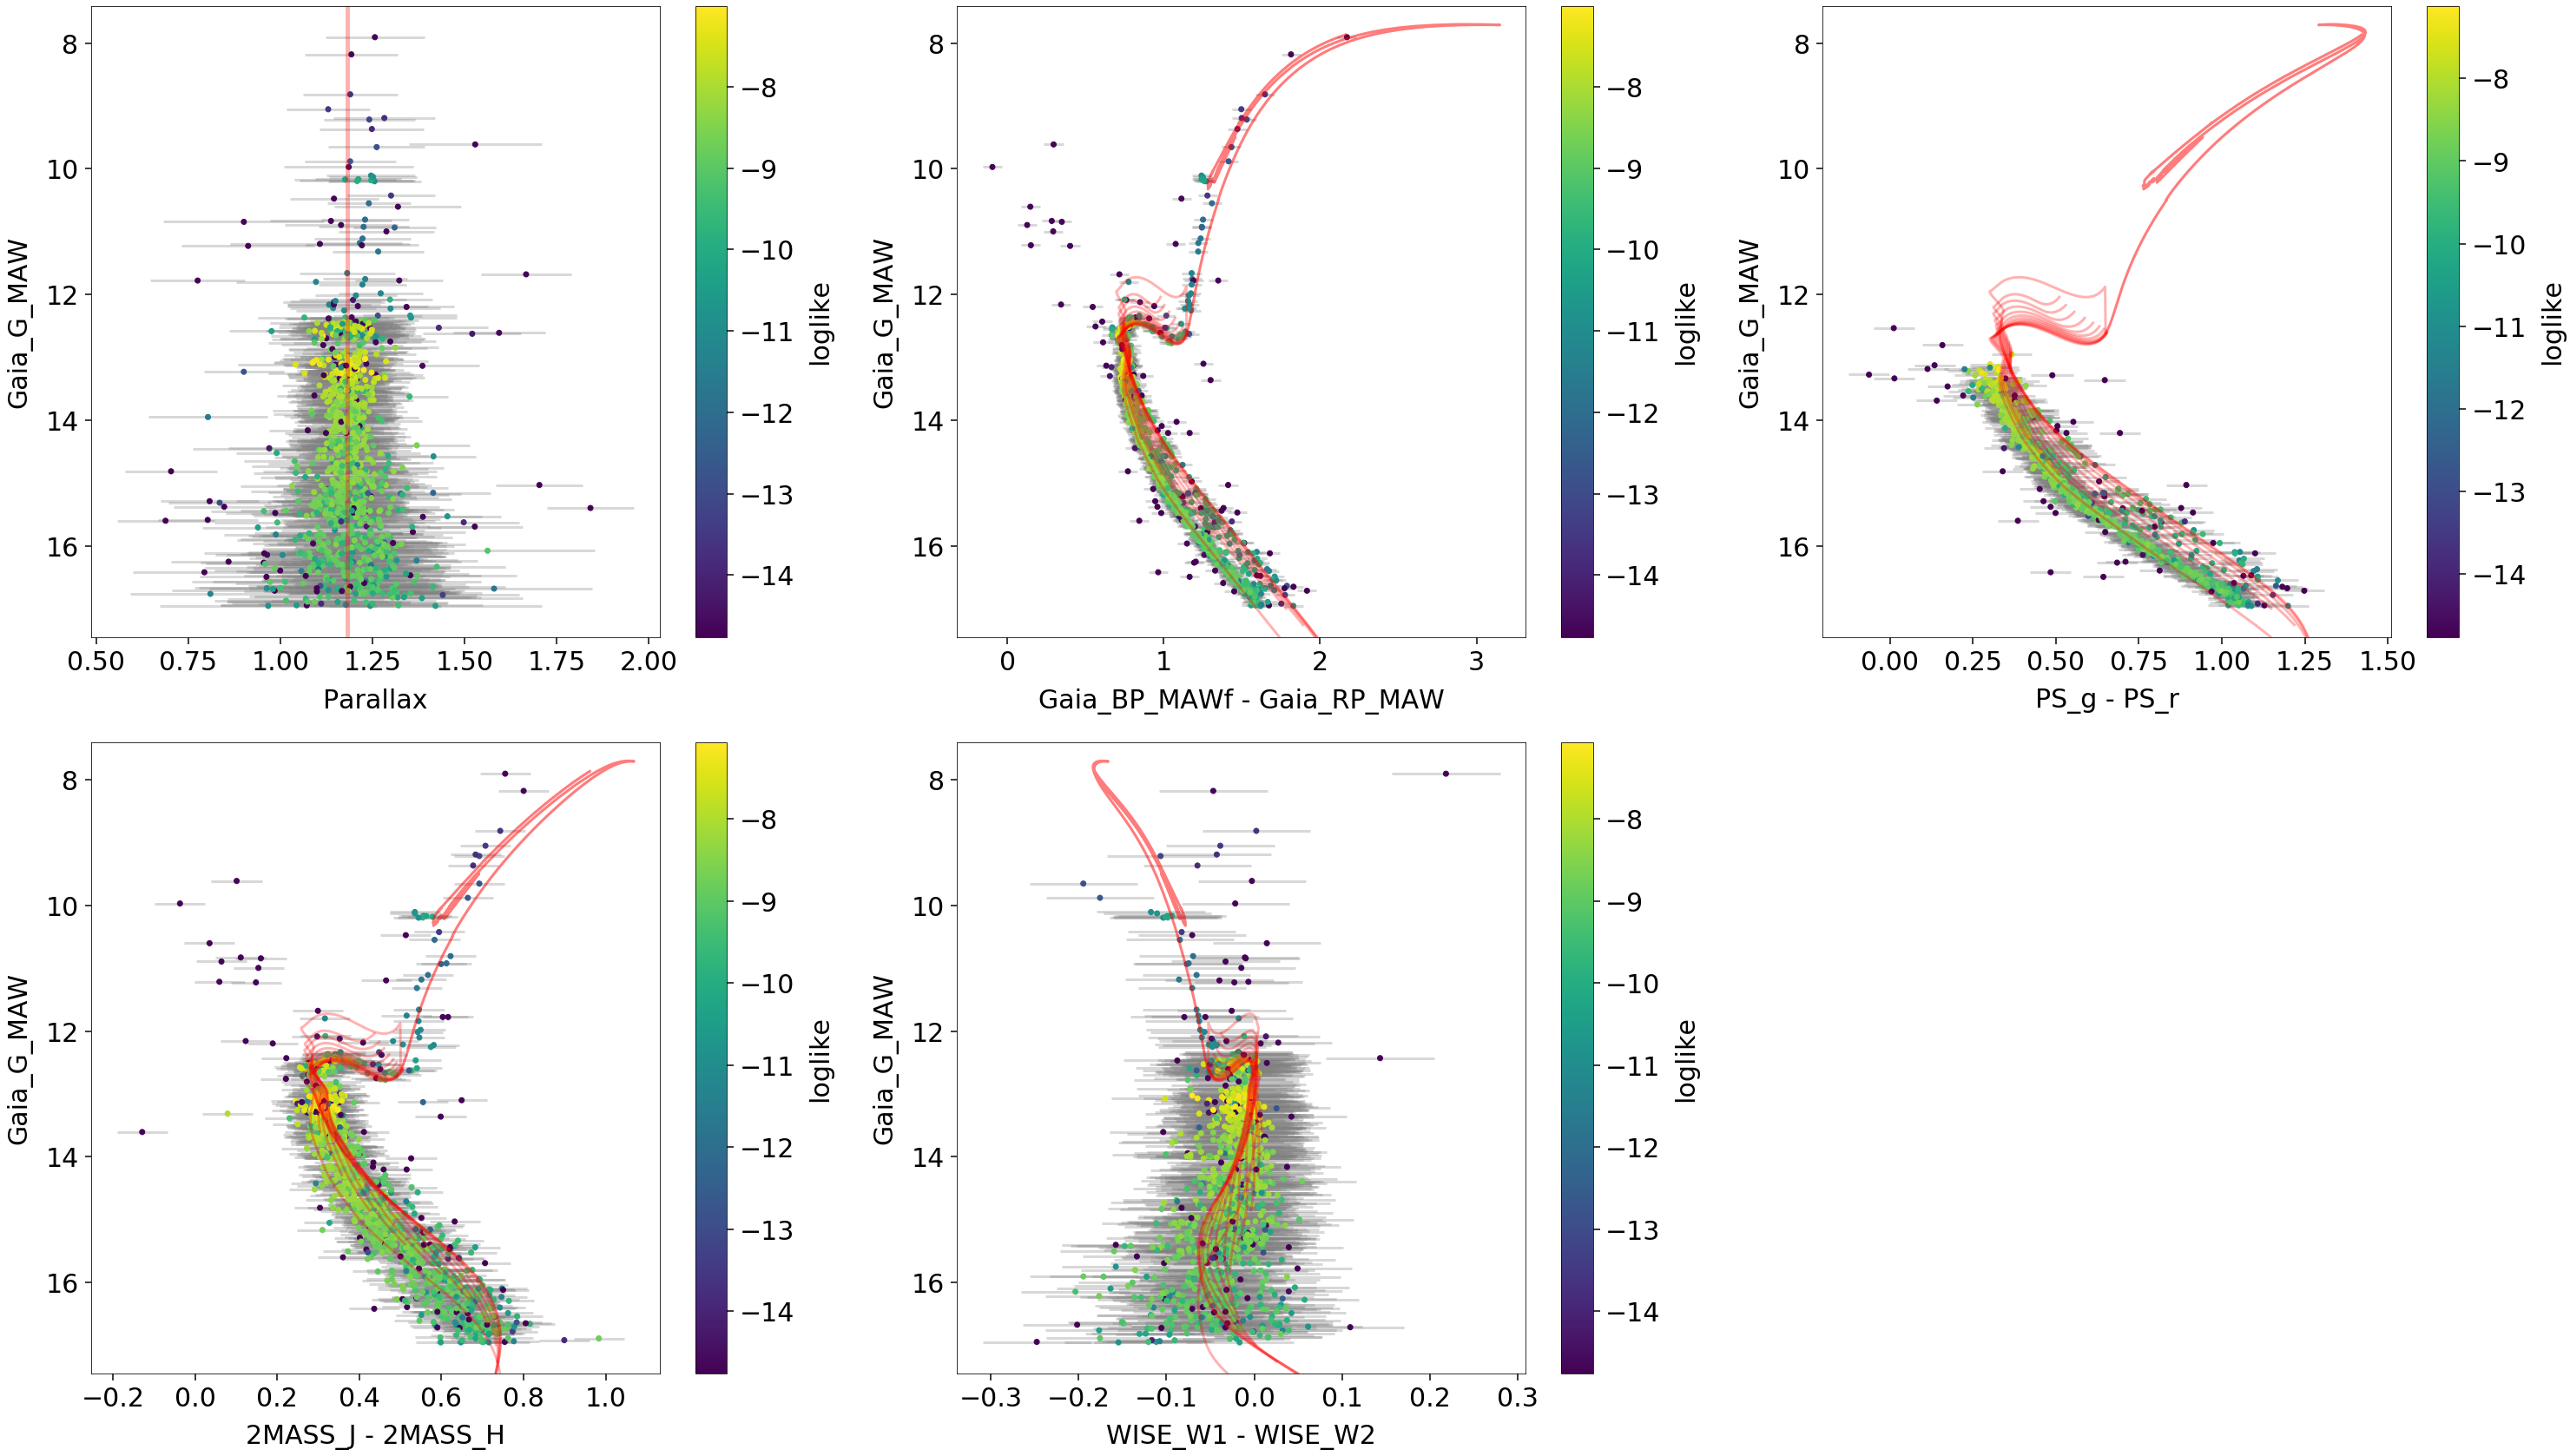

In [30]:
# new parameters
theta = results['x']
feh, loga, av, rv, dist, fout = theta[:6]
offsets = theta[6:]

# new likelihoods
lnl, lnls = loglike(theta, iso, phot, err,
                    parallax=parallax, parallax_err=parallax_err,
                    cluster_params='free', offsets='free',
                    return_lnls=True)

# new isochrones
mags = []
for smf in smf_grid:
    mags.append(iso.get_seds(feh=feh, loga=loga, smf=smf,
                             av=av, rv=rv, eep=eep_grid,
                             dist=dist)[0])

# plot results
plot_cmds(phot, err, info, parallax, parallax_err,
          iso_mags=mags, dist=dist, lnls=lnls,
          offsets=offsets)

Awesome! That looks like (and quantitatively is) a much better fit.

## Empirical Corrections

By default, the isochrones implemented in `brutus` include a series of **empirical corrections** as described in Speagle et al. (2020a). The parameters that control these can be sampled for as part of the log-likelihood by setting `corr_params='free'`. However, doing so is ***not recommended*** since several of the parameters are incredibly degenerate and only constrained across many clusters of varying ages and metallicities. That said, we will demonstrate the functionality for completeness by examining the changes in the isochrone and corresponding log-likelihood when these corrections are entirely disabled.

-10174.036506668957


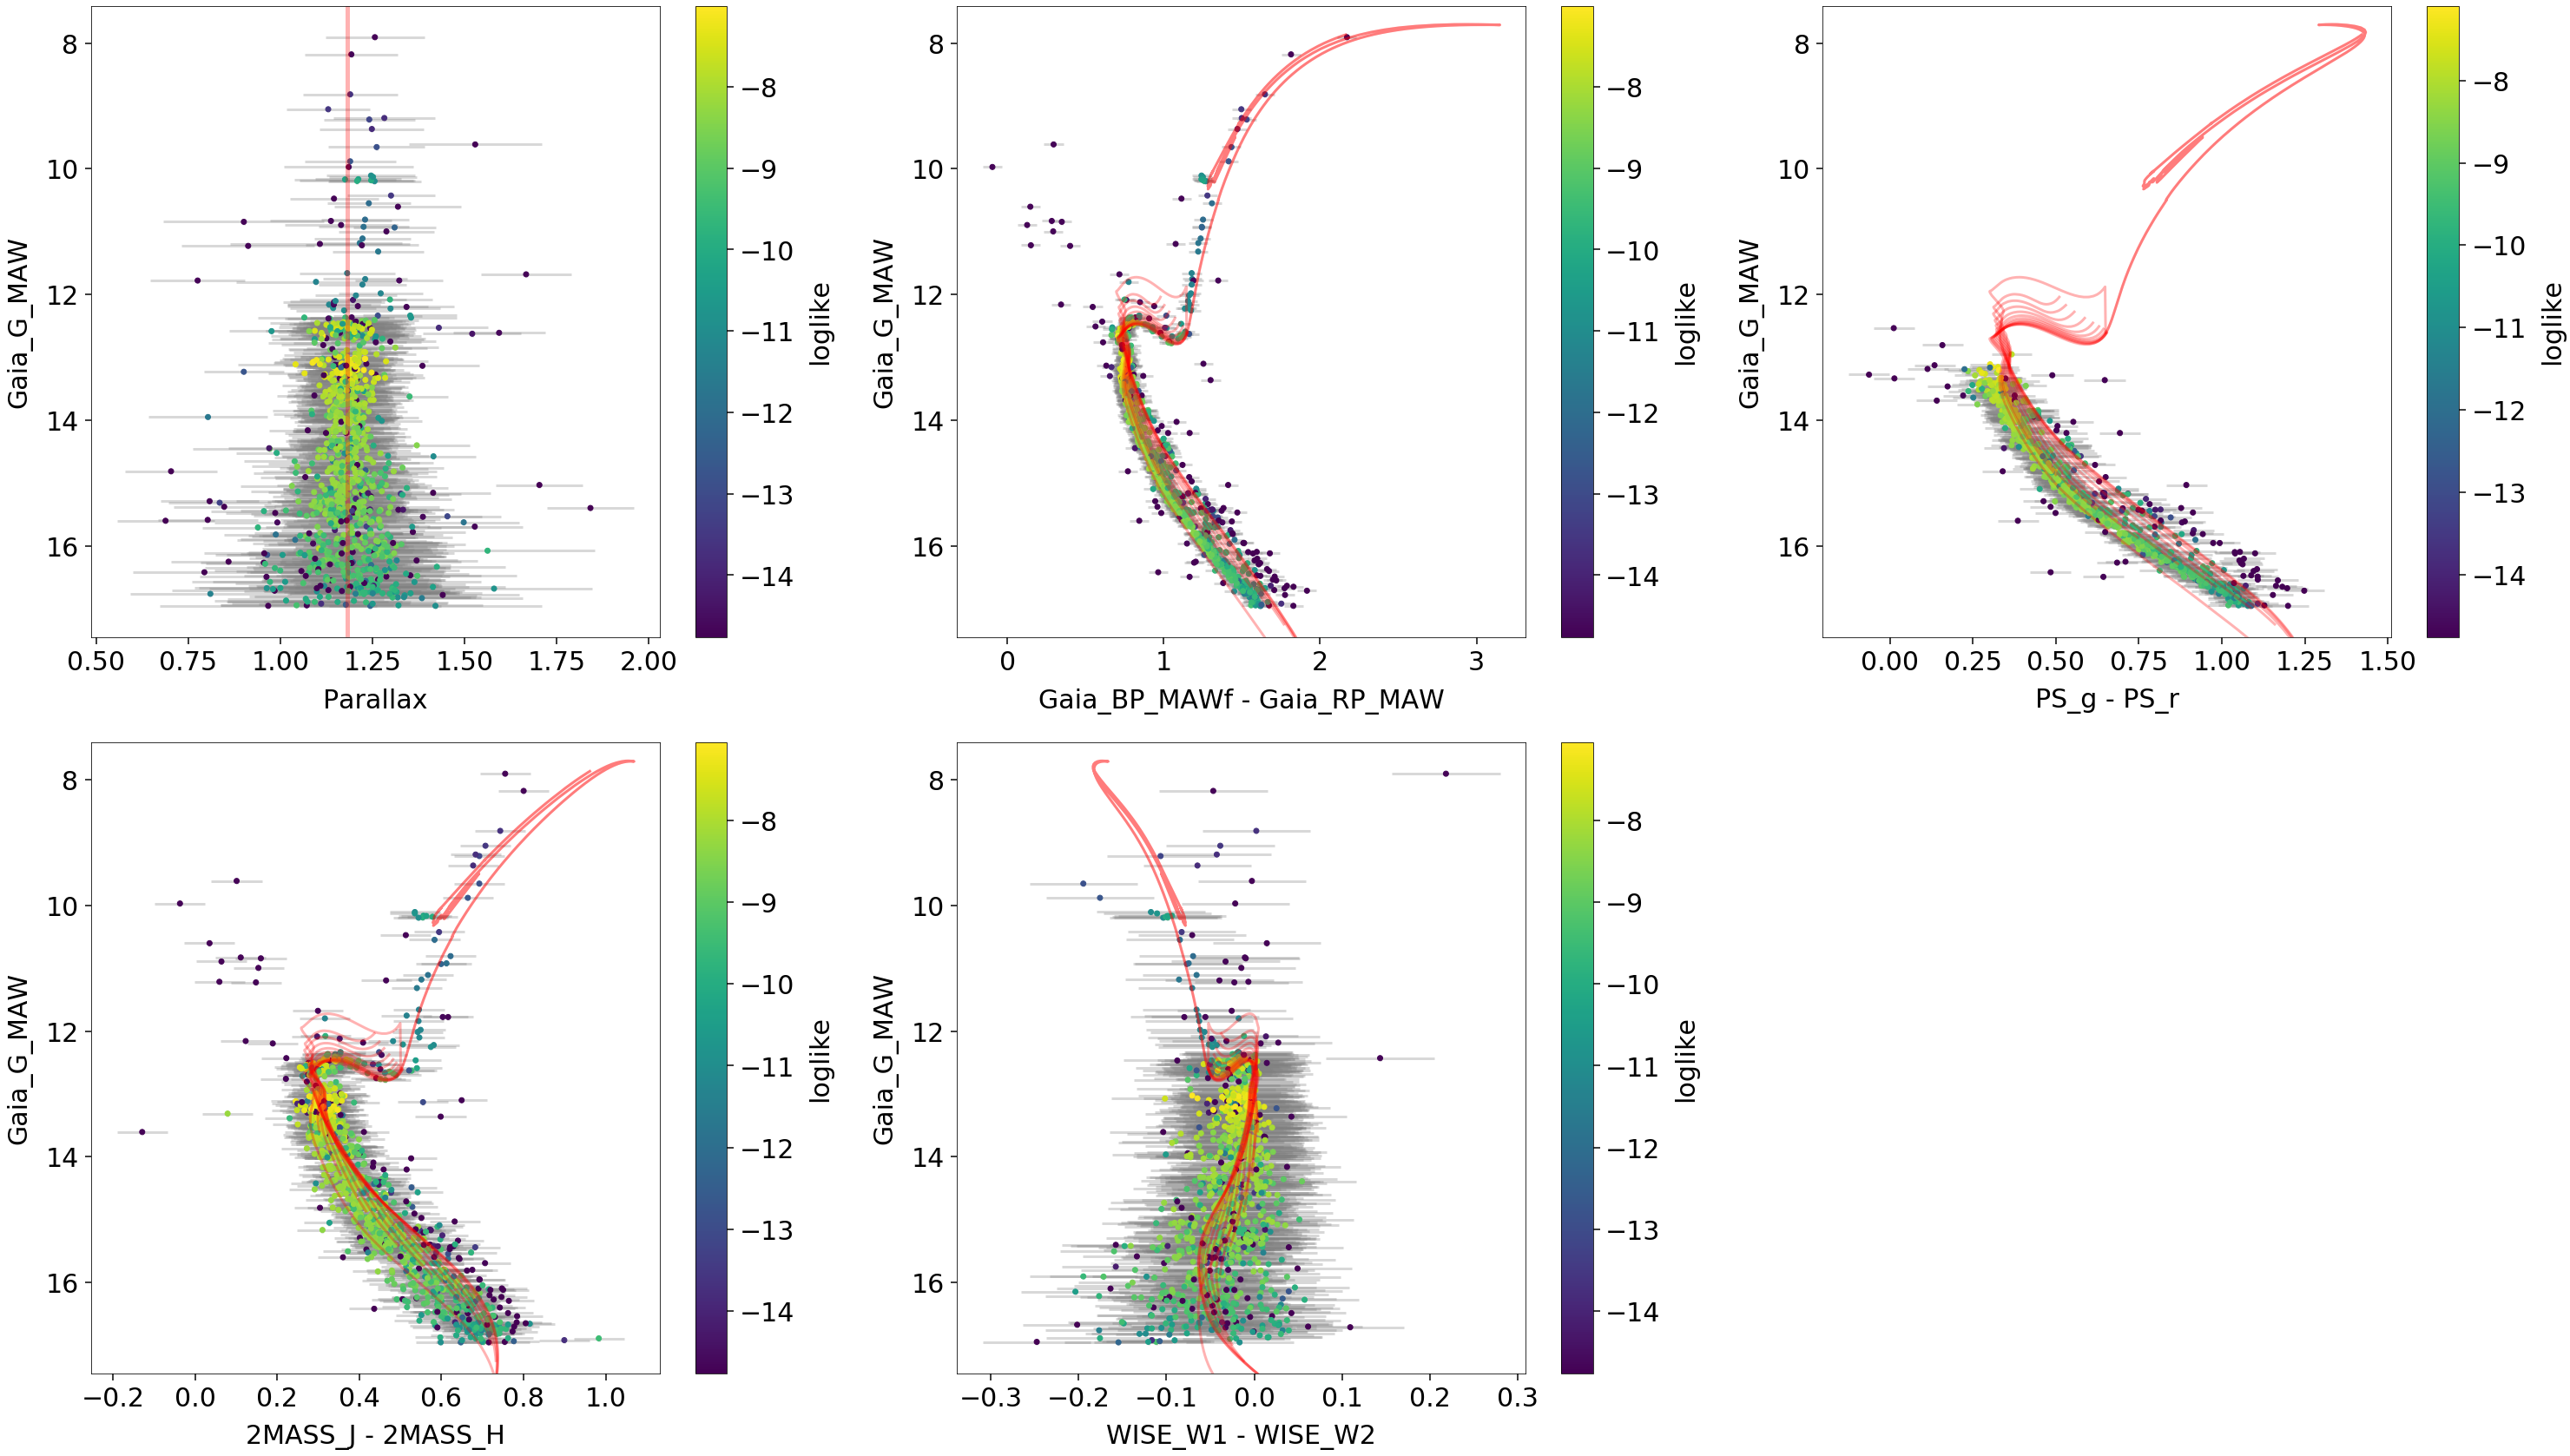

In [31]:
# new likelihoods
lnl, lnls = loglike(theta, iso, phot, err,
                    parallax=parallax, parallax_err=parallax_err,
                    cluster_params='free', offsets='free',
                    corr_params=[0., 0., 30., 0.5],  # specify `corr_params` manually
                    return_lnls=True)

# new isochrones
mags = []
for smf in smf_grid:
    mags.append(iso.get_seds(feh=feh, loga=loga, smf=smf,
                             av=av, rv=rv, eep=eep_grid,
                             corr_params=[0., 0., 30., 0.5],
                             dist=dist)[0])

# plot results
plot_cmds(phot, err, info, parallax, parallax_err,
          iso_mags=mags, dist=dist, lnls=lnls,
          offsets=offsets)

print(lnl)

-9969.893186608875


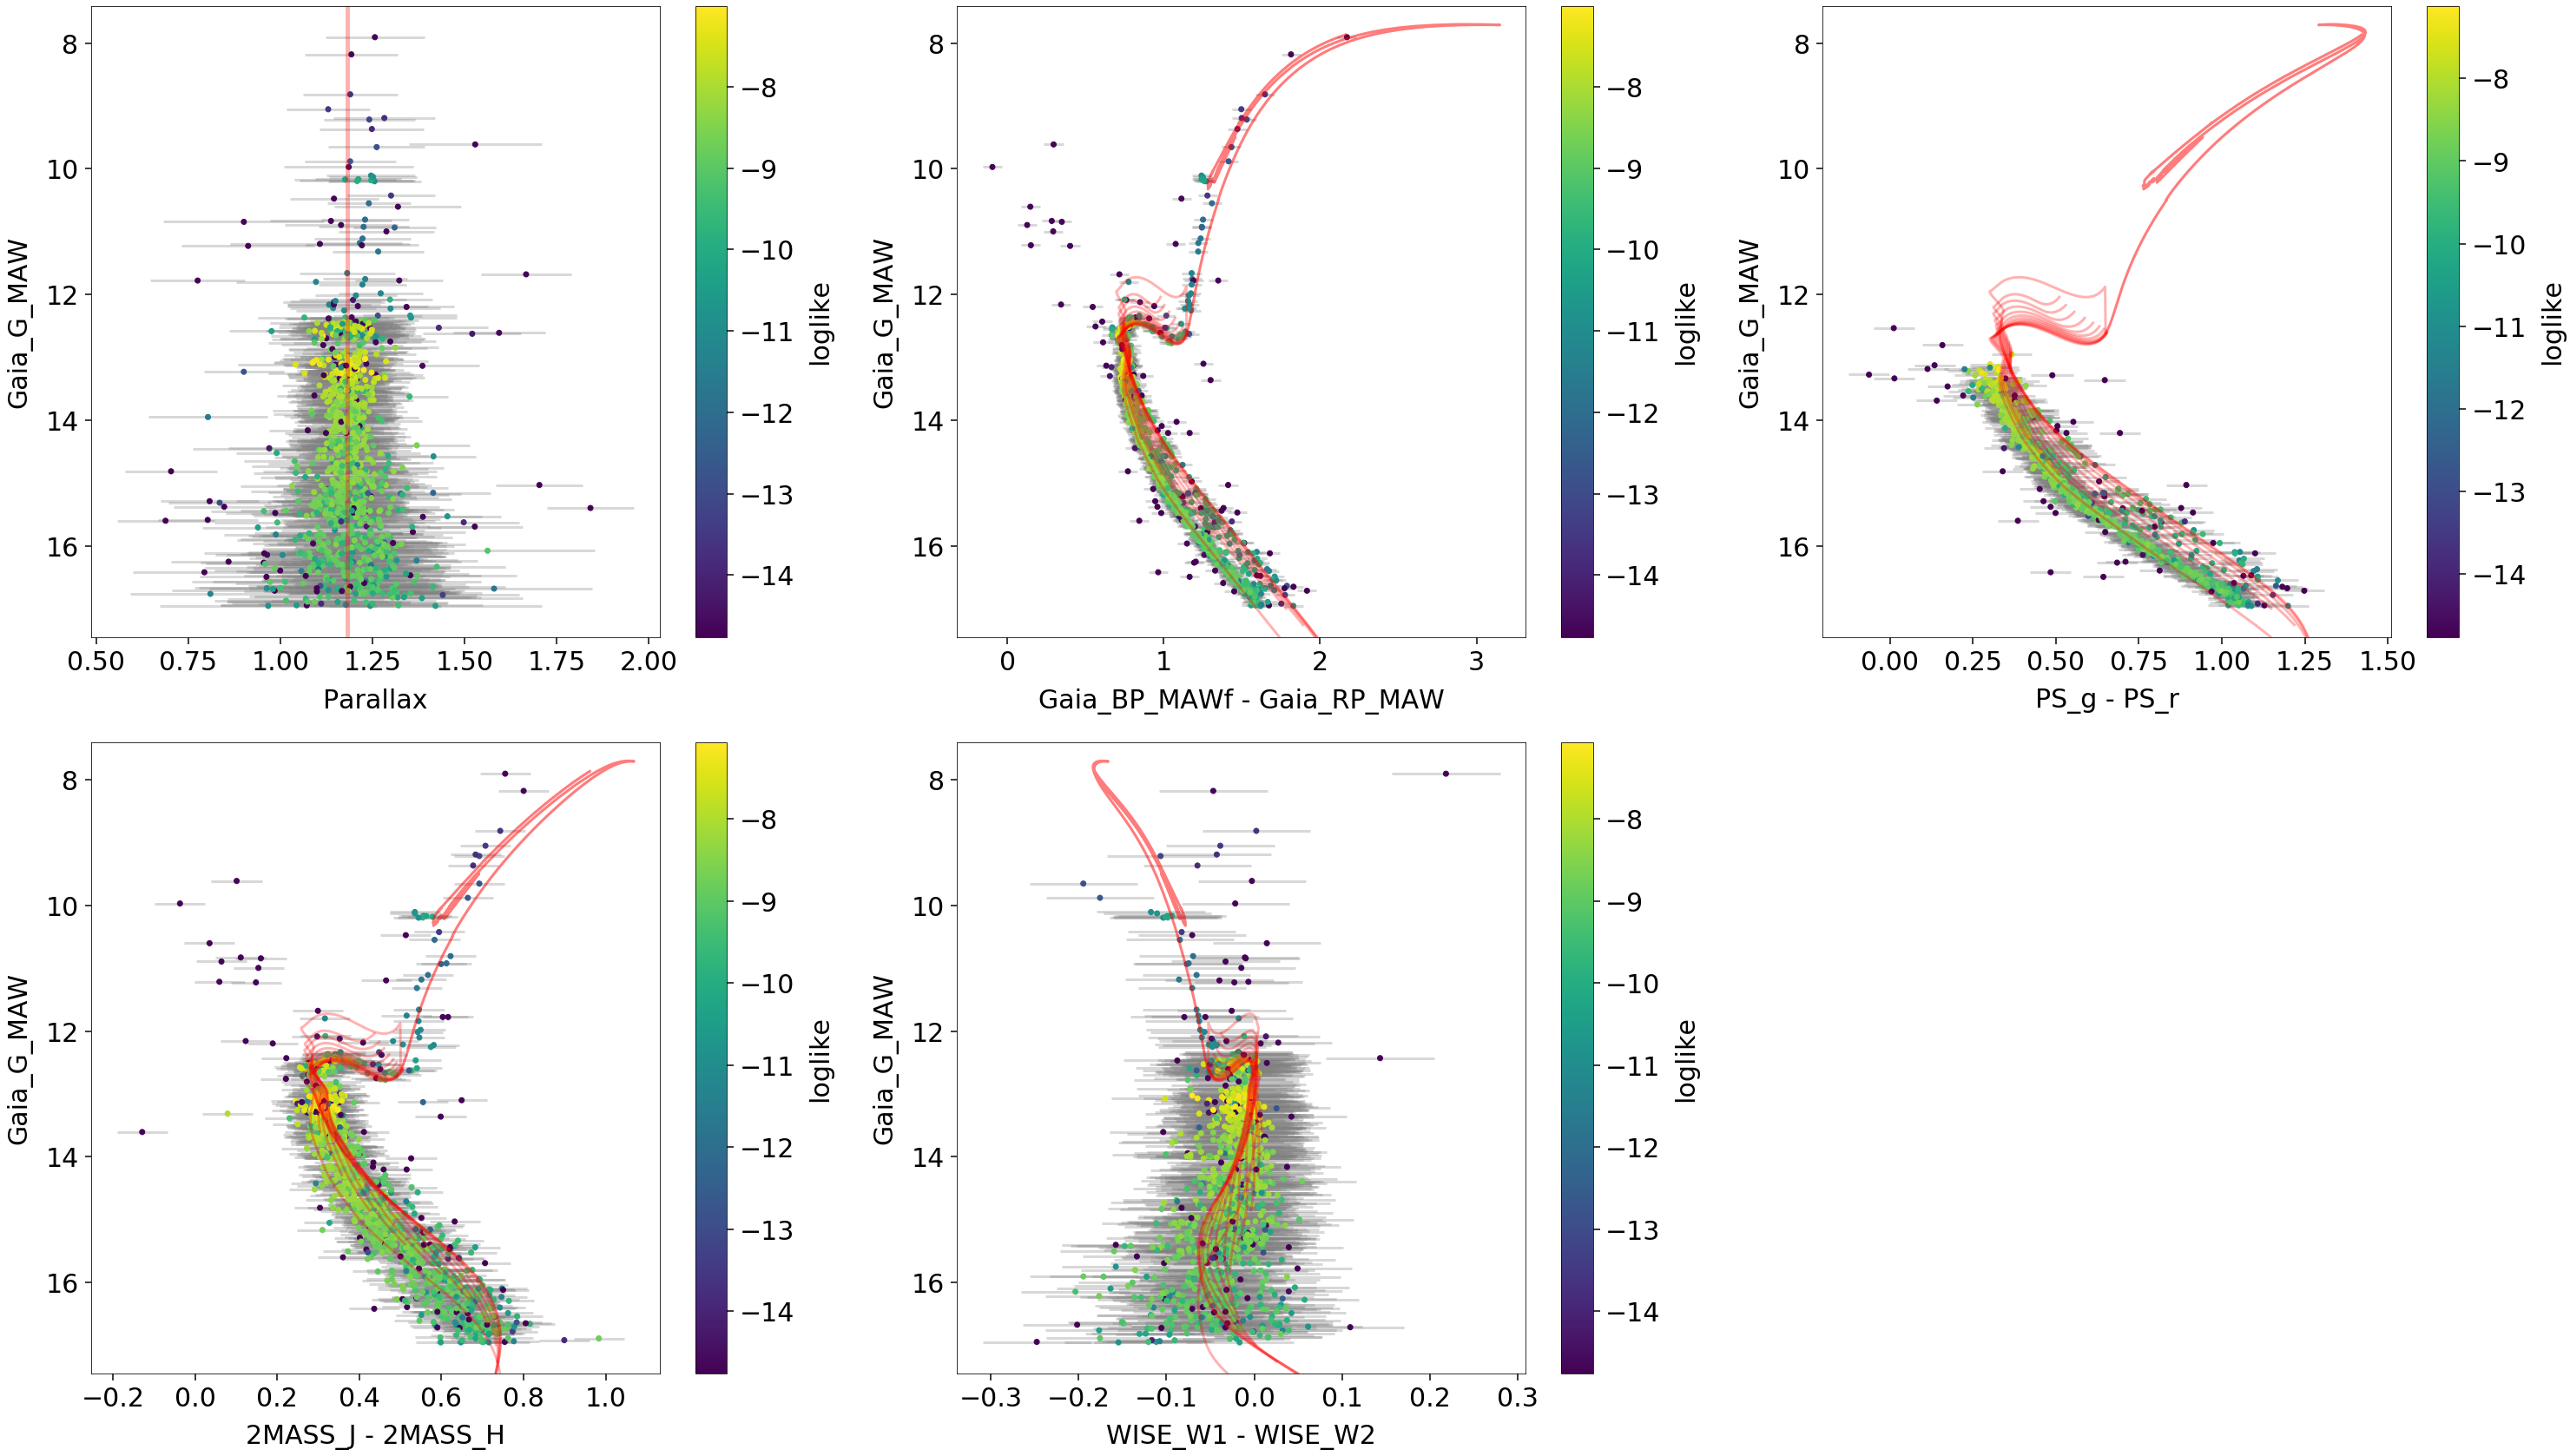

In [32]:
# new likelihoods
lnl, lnls = loglike(theta, iso, phot, err,
                    parallax=parallax, parallax_err=parallax_err,
                    cluster_params='free', offsets='free',
                    corr_params='fixed',  # use defaults
                    return_lnls=True)

# new isochrones
mags = []
for smf in smf_grid:
    mags.append(iso.get_seds(feh=feh, loga=loga, smf=smf,
                             av=av, rv=rv, eep=eep_grid,
                             dist=dist)[0])

# plot results
plot_cmds(phot, err, info, parallax, parallax_err,
          iso_mags=mags, dist=dist, lnls=lnls,
          offsets=offsets)

print(lnl)

We see that the empirical corrections help to correct for the shape of the isochrone at lower masses. While this improves the fits for most low-mass objects, in this particular case it shows up particularly clearly in the failure to properly model the lower-mass binary main sequence.